In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [11]:
from tensorflow.keras.datasets import mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32") / 255.0

# Check shape
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28)


In [3]:
from tensorflow import keras
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,609 (1.51 MB)

 Trainable params: 396,609 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │         3,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,017 (3.93 MB)

 Trainable params: 1,030,017 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # it is use to update thee weight
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [16]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images.numpy()

        plt.figure(figsize=(5, 5))
        for i in range(self.num_img):
            plt.subplot(3, 4, i + 1)
            plt.imshow(generated_images[i].squeeze(), cmap="gray")
            plt.axis("off")
        plt.show()


In [17]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

Epoch 1/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - d_loss: 0.5373 - g_loss: 1.3977

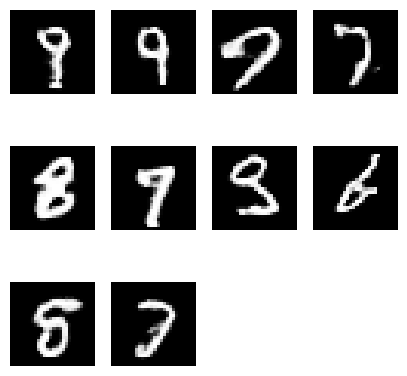

469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - d_loss: 0.5373 - g_loss: 1.3976
Epoch 2/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 0.5023 - g_loss: 1.3676

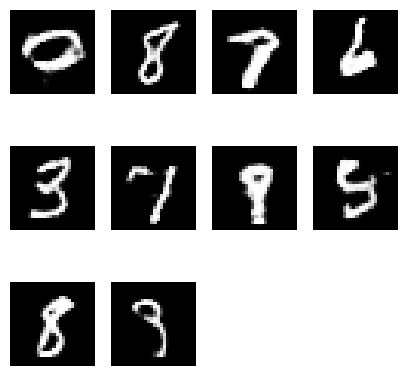

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - d_loss: 0.5023 - g_loss: 1.3676
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 0.5073 - g_loss: 1.4074

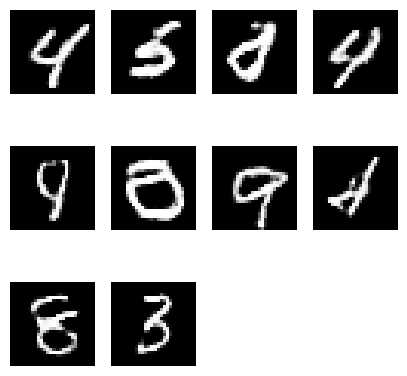

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - d_loss: 0.5073 - g_loss: 1.4074
Epoch 4/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 0.5066 - g_loss: 1.3789

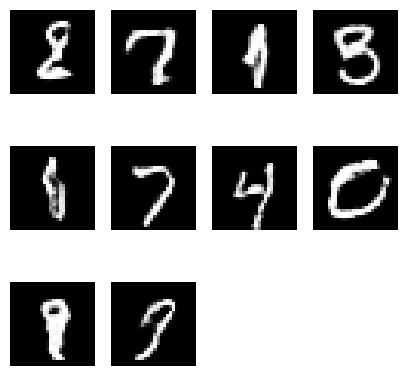

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - d_loss: 0.5066 - g_loss: 1.3788
Epoch 5/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 0.5031 - g_loss: 1.3795

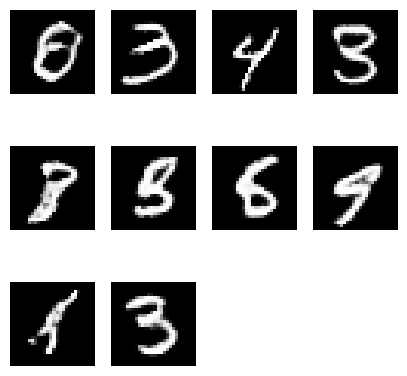

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5031 - g_loss: 1.3795
Epoch 6/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 0.5098 - g_loss: 1.3720

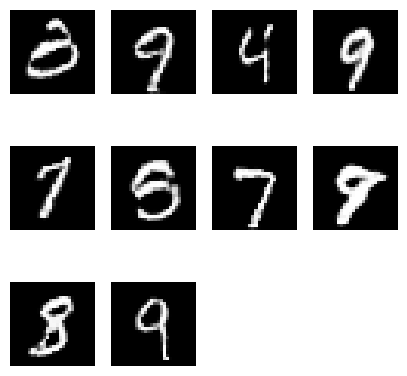

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - d_loss: 0.5098 - g_loss: 1.3719
Epoch 7/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 0.5078 - g_loss: 1.3497

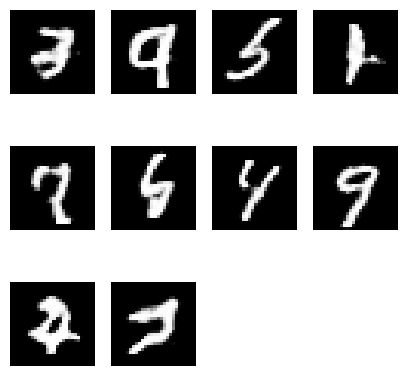

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - d_loss: 0.5078 - g_loss: 1.3496
Epoch 8/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 0.5079 - g_loss: 1.3508

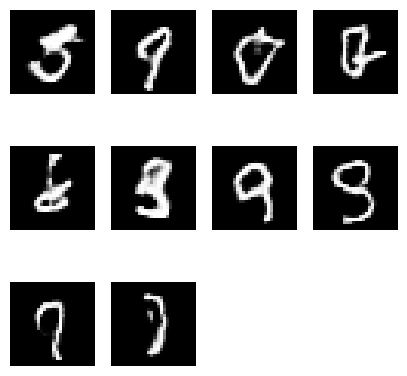

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5079 - g_loss: 1.3508
Epoch 9/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 0.5152 - g_loss: 1.3803

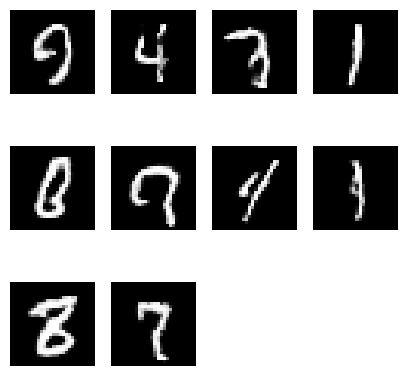

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5152 - g_loss: 1.3803
Epoch 10/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.5158 - g_loss: 1.3946

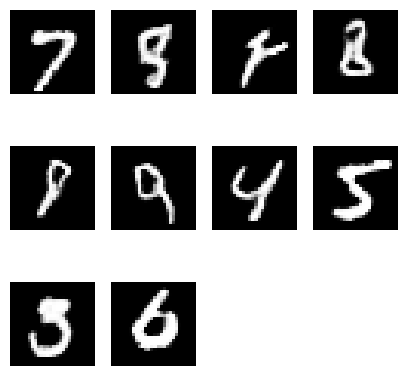

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5157 - g_loss: 1.3946
Epoch 11/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.5135 - g_loss: 1.3344

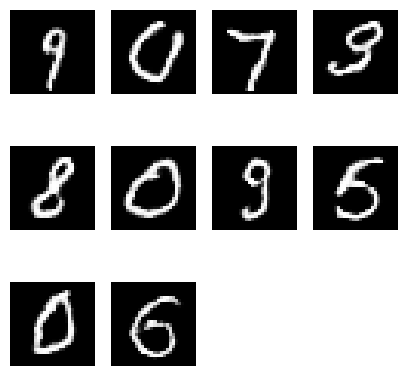

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5134 - g_loss: 1.3343
Epoch 12/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.5100 - g_loss: 1.3224

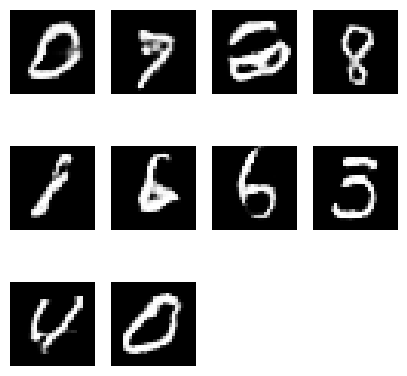

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5100 - g_loss: 1.3224
Epoch 13/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.5168 - g_loss: 1.3739

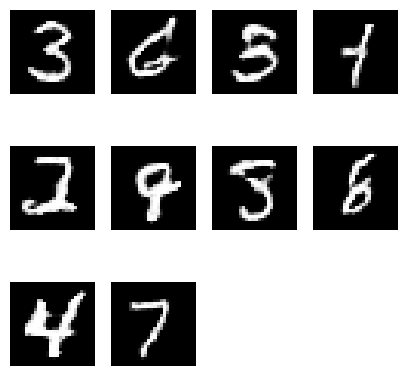

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5168 - g_loss: 1.3738
Epoch 14/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5148 - g_loss: 1.3568

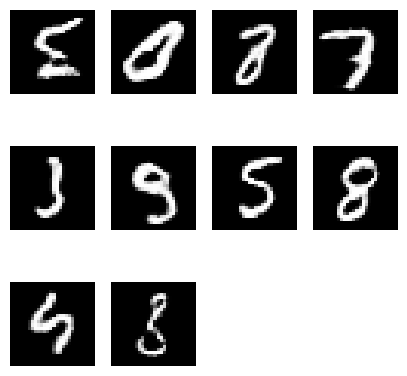

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5148 - g_loss: 1.3568
Epoch 15/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5142 - g_loss: 1.3412

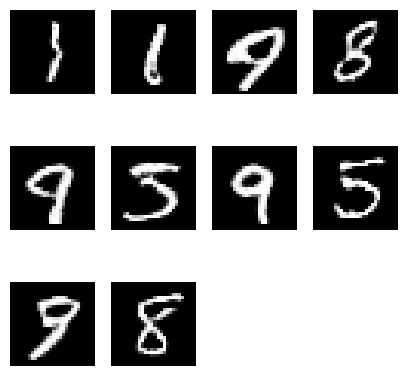

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5142 - g_loss: 1.3412
Epoch 16/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5110 - g_loss: 1.3376

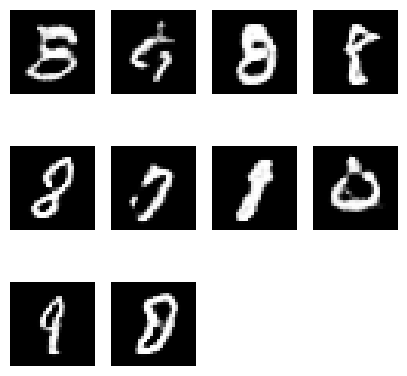

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5110 - g_loss: 1.3376
Epoch 17/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5100 - g_loss: 1.3779

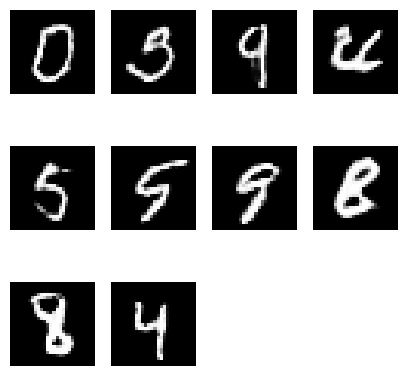

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5100 - g_loss: 1.3778
Epoch 18/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5087 - g_loss: 1.3387

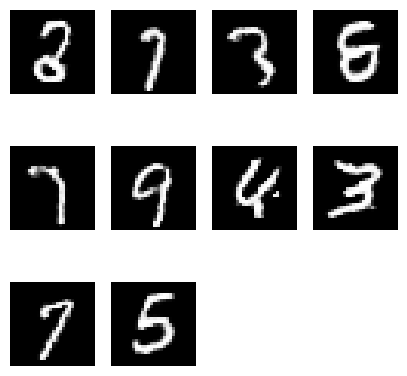

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5087 - g_loss: 1.3387
Epoch 19/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5124 - g_loss: 1.3531

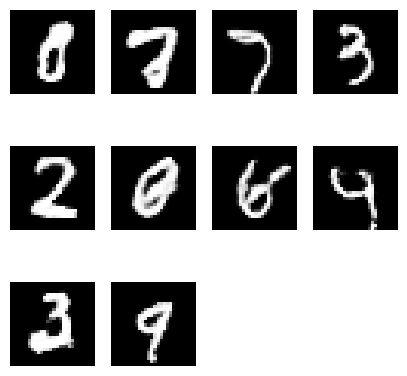

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5124 - g_loss: 1.3531
Epoch 20/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5098 - g_loss: 1.3493

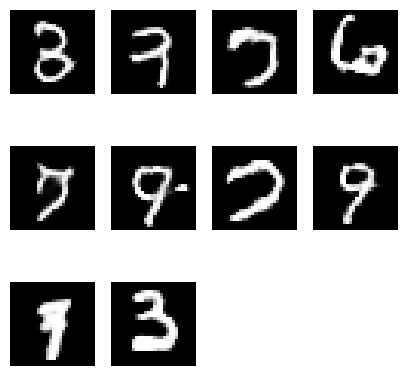

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5098 - g_loss: 1.3493
Epoch 21/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5113 - g_loss: 1.3232

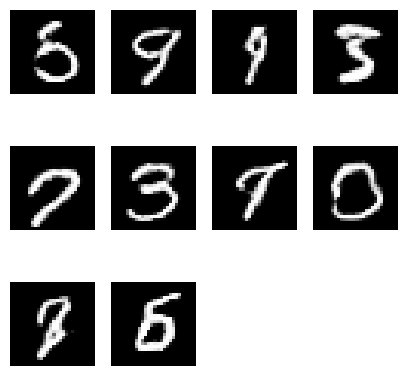

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5113 - g_loss: 1.3232
Epoch 22/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5167 - g_loss: 1.3329

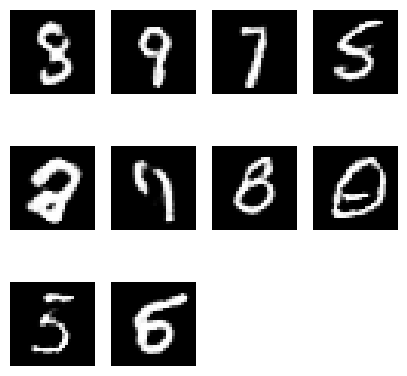

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5167 - g_loss: 1.3329
Epoch 23/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5106 - g_loss: 1.3280

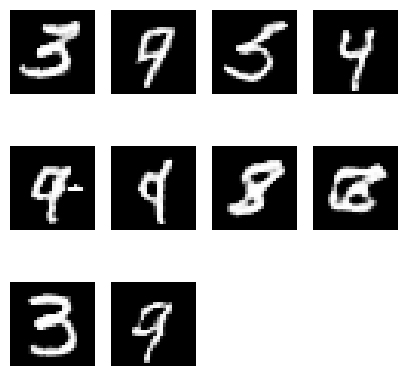

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5106 - g_loss: 1.3280
Epoch 24/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5152 - g_loss: 1.3325

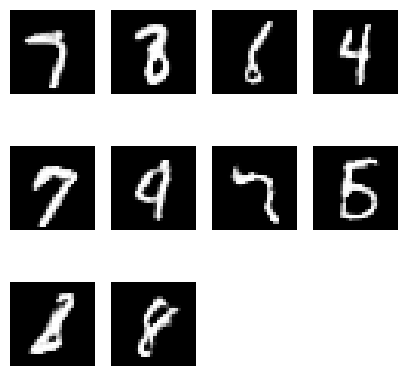

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5152 - g_loss: 1.3325
Epoch 25/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5189 - g_loss: 1.3354

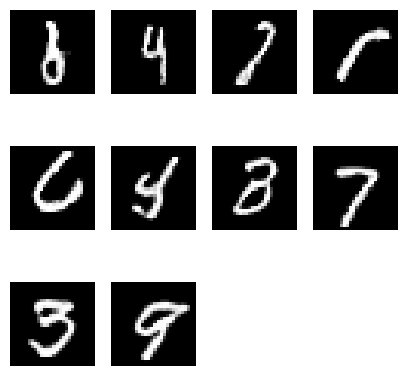

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5189 - g_loss: 1.3354
Epoch 26/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5195 - g_loss: 1.3397

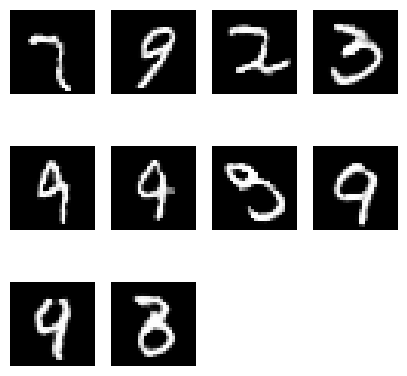

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5195 - g_loss: 1.3397
Epoch 27/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5161 - g_loss: 1.3246

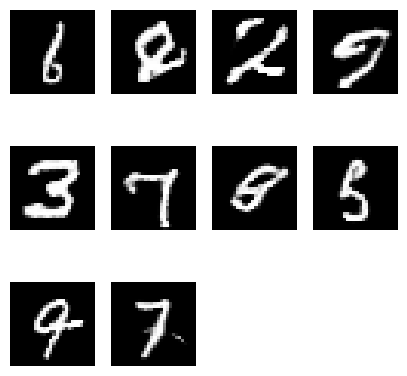

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5161 - g_loss: 1.3246
Epoch 28/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5153 - g_loss: 1.3162

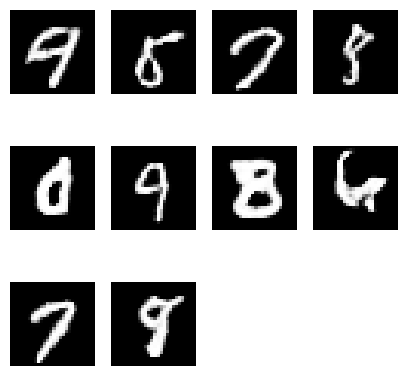

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5153 - g_loss: 1.3162
Epoch 29/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5145 - g_loss: 1.3167

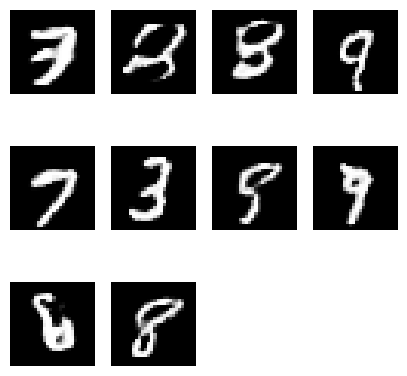

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5145 - g_loss: 1.3167
Epoch 30/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5163 - g_loss: 1.3523

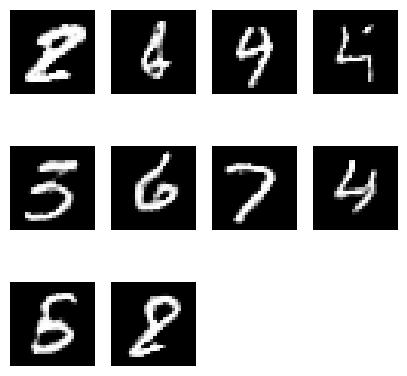

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5163 - g_loss: 1.3523
Epoch 31/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5171 - g_loss: 1.3185

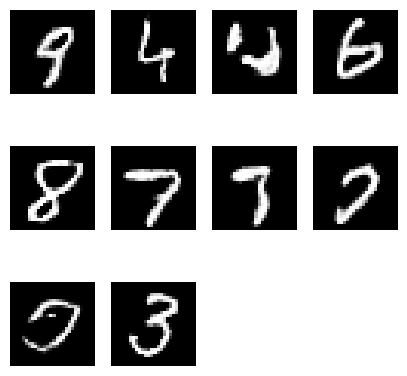

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5171 - g_loss: 1.3185
Epoch 32/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5147 - g_loss: 1.3401

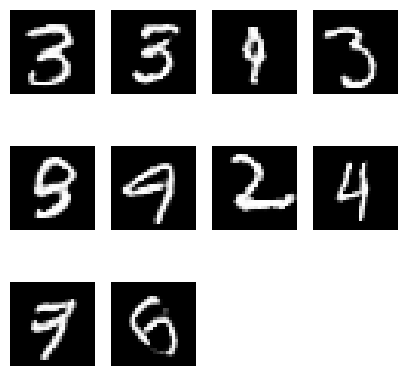

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5147 - g_loss: 1.3401
Epoch 33/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5190 - g_loss: 1.3196

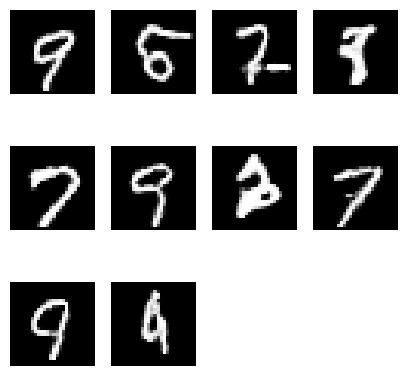

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5190 - g_loss: 1.3196
Epoch 34/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5166 - g_loss: 1.3388

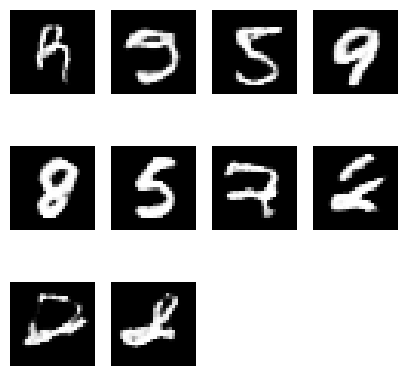

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5166 - g_loss: 1.3388
Epoch 35/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5212 - g_loss: 1.3185

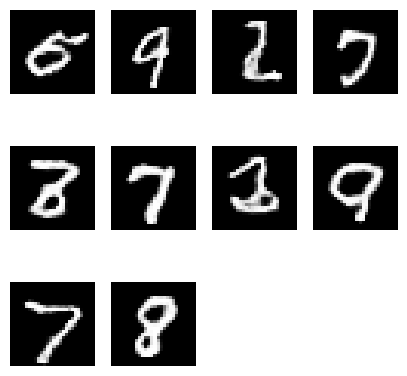

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5212 - g_loss: 1.3184
Epoch 36/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5131 - g_loss: 1.3157

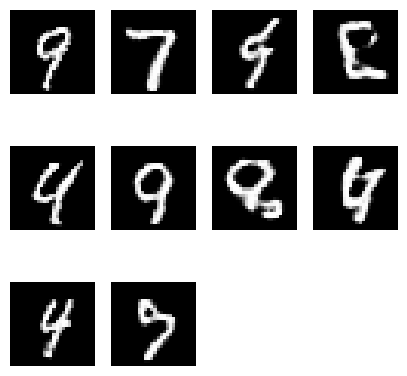

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5131 - g_loss: 1.3157
Epoch 37/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5140 - g_loss: 1.3331

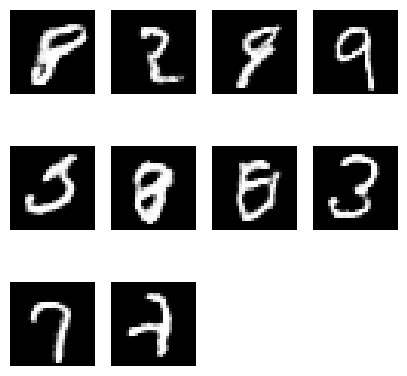

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5140 - g_loss: 1.3331
Epoch 38/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5164 - g_loss: 1.3127

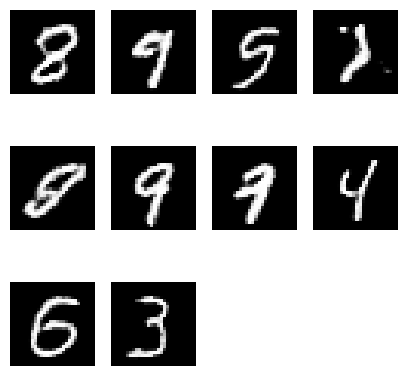

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5164 - g_loss: 1.3127
Epoch 39/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5173 - g_loss: 1.3296

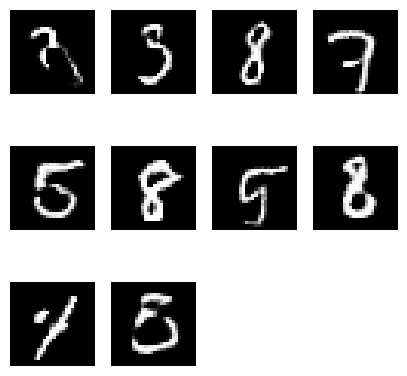

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5173 - g_loss: 1.3296
Epoch 40/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5157 - g_loss: 1.3381

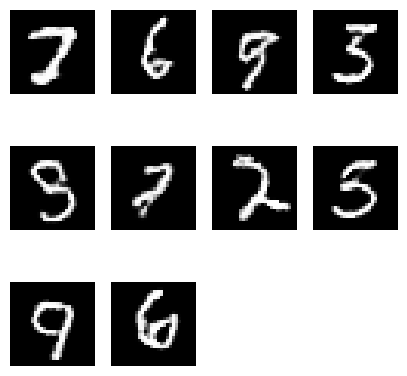

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5157 - g_loss: 1.3381
Epoch 41/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5198 - g_loss: 1.3488

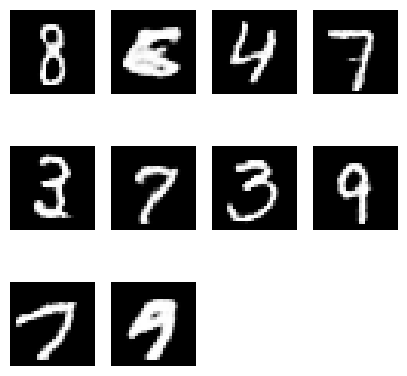

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5198 - g_loss: 1.3487
Epoch 42/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5165 - g_loss: 1.3278

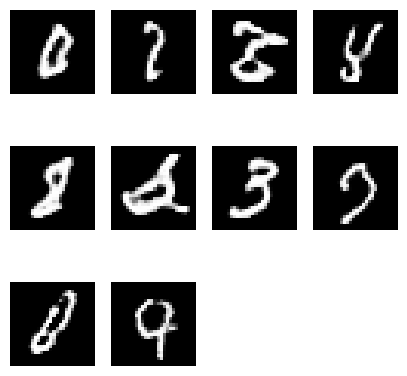

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5165 - g_loss: 1.3278
Epoch 43/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5151 - g_loss: 1.3141

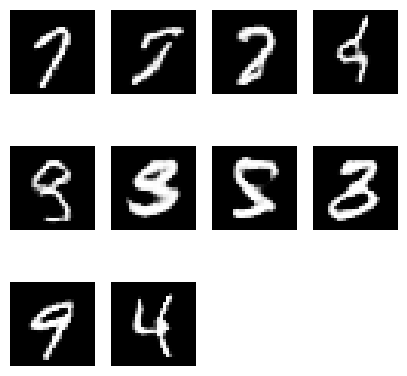

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.5151 - g_loss: 1.3141
Epoch 44/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5194 - g_loss: 1.3496

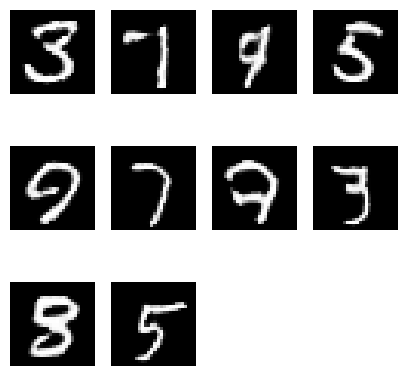

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5194 - g_loss: 1.3496
Epoch 45/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5191 - g_loss: 1.3153

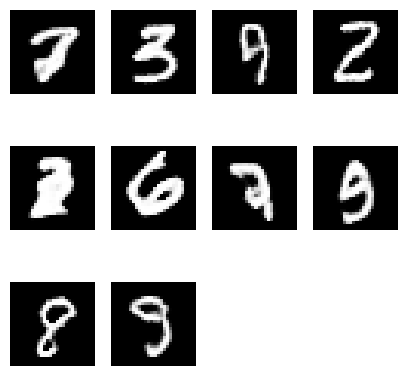

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5191 - g_loss: 1.3153
Epoch 46/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5155 - g_loss: 1.3212

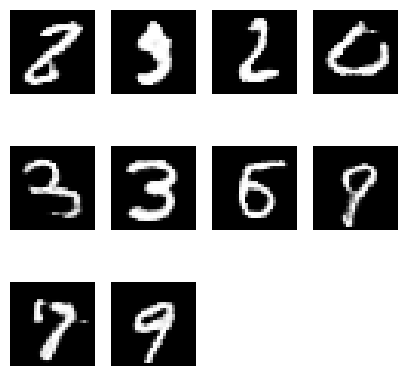

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5155 - g_loss: 1.3212
Epoch 47/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5197 - g_loss: 1.3255

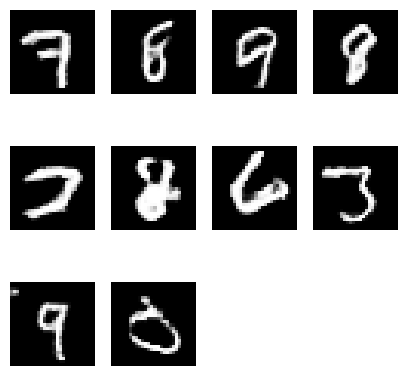

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5197 - g_loss: 1.3255
Epoch 48/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5173 - g_loss: 1.3044

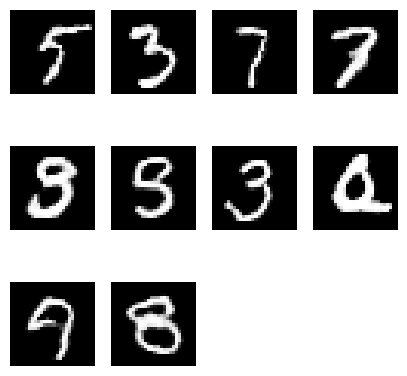

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5173 - g_loss: 1.3044
Epoch 49/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5197 - g_loss: 1.3250

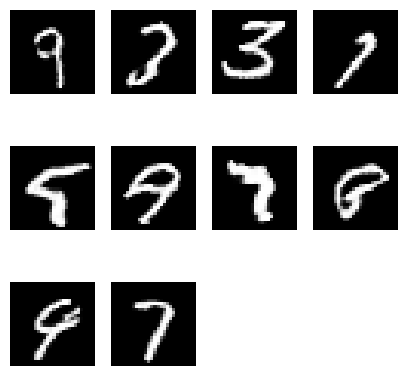

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5197 - g_loss: 1.3250
Epoch 50/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5205 - g_loss: 1.3122

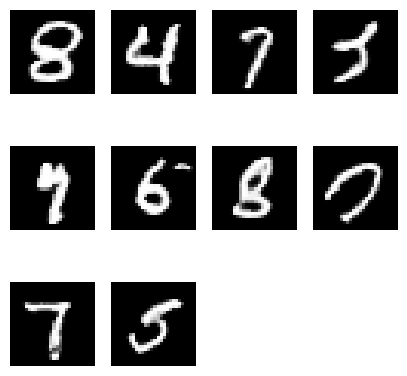

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5205 - g_loss: 1.3122
Epoch 51/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5153 - g_loss: 1.3100

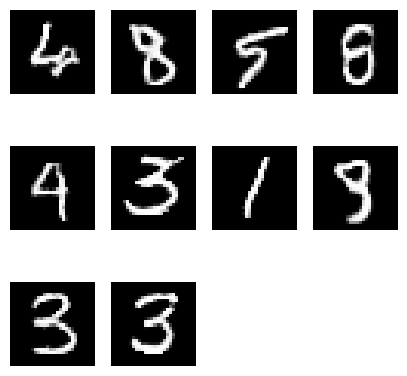

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5154 - g_loss: 1.3100
Epoch 52/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5161 - g_loss: 1.3228

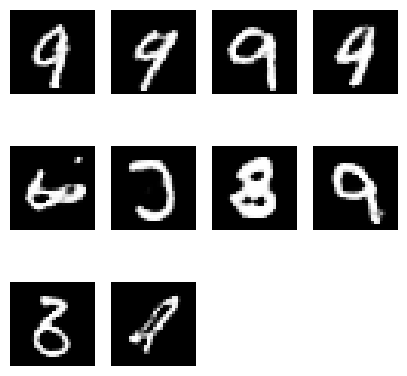

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5161 - g_loss: 1.3228
Epoch 53/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5186 - g_loss: 1.3356

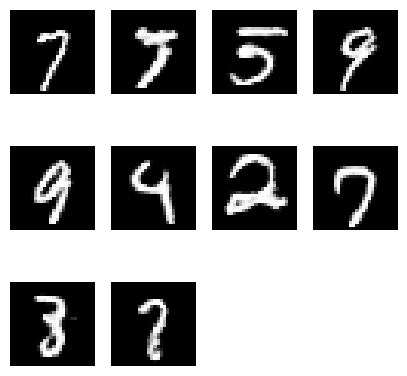

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5186 - g_loss: 1.3356
Epoch 54/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5163 - g_loss: 1.3410

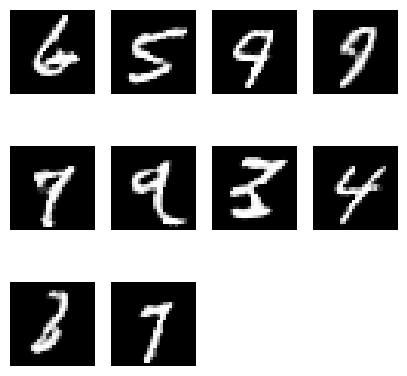

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5163 - g_loss: 1.3409
Epoch 55/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5174 - g_loss: 1.3117

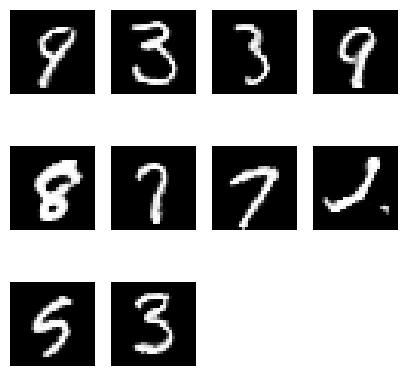

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5174 - g_loss: 1.3117
Epoch 56/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5200 - g_loss: 1.2936

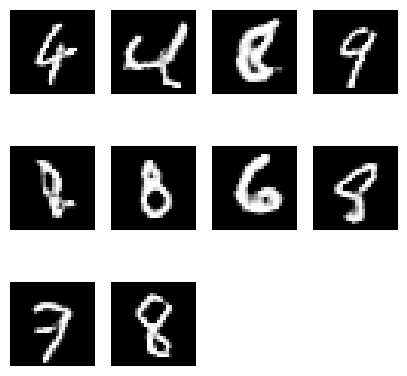

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5200 - g_loss: 1.2936
Epoch 57/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5195 - g_loss: 1.3119

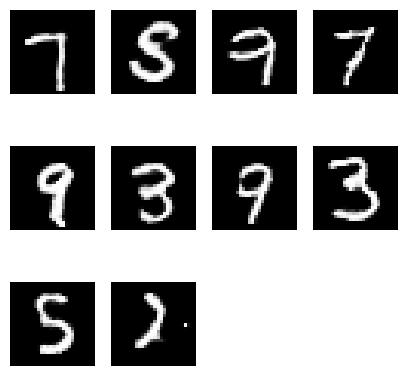

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5195 - g_loss: 1.3119
Epoch 58/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5216 - g_loss: 1.3509

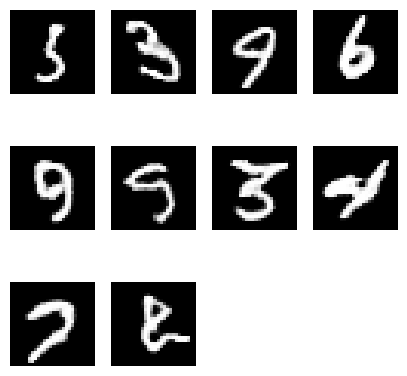

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5216 - g_loss: 1.3509
Epoch 59/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5209 - g_loss: 1.3246

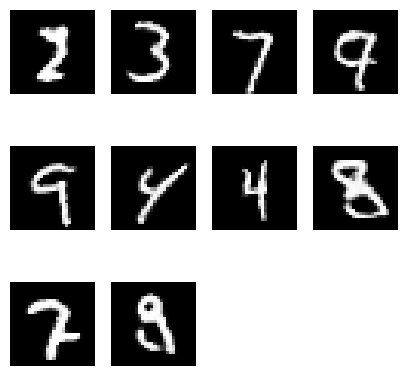

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5209 - g_loss: 1.3246
Epoch 60/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5177 - g_loss: 1.3062

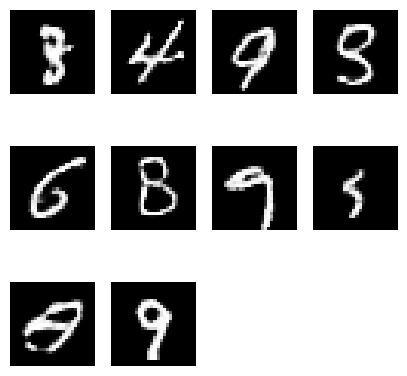

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5177 - g_loss: 1.3062
Epoch 61/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5201 - g_loss: 1.3086

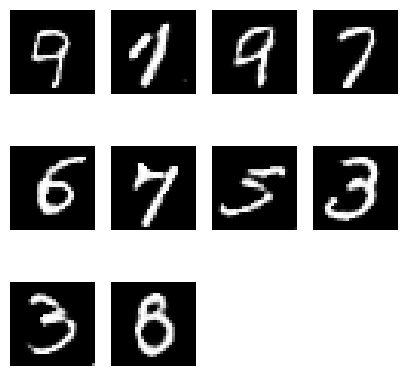

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5201 - g_loss: 1.3086
Epoch 62/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5213 - g_loss: 1.3321

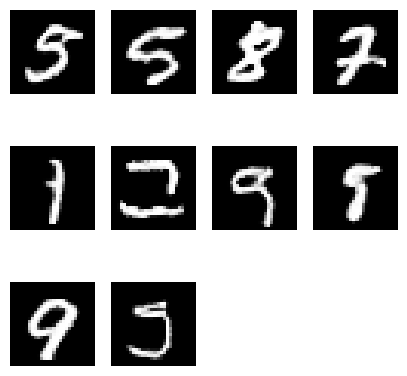

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5213 - g_loss: 1.3320
Epoch 63/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5176 - g_loss: 1.3035

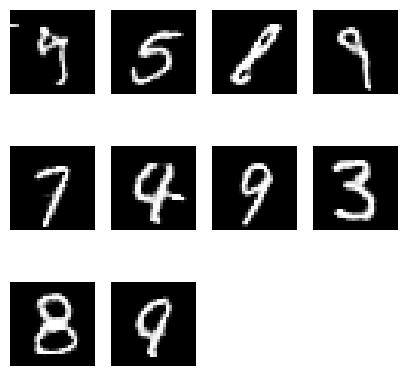

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5176 - g_loss: 1.3035
Epoch 64/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5200 - g_loss: 1.3207

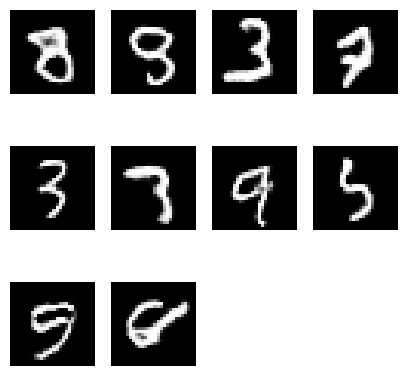

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5200 - g_loss: 1.3207
Epoch 65/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5185 - g_loss: 1.3228

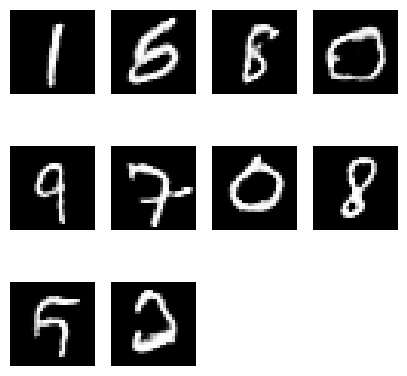

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5185 - g_loss: 1.3228
Epoch 66/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5207 - g_loss: 1.3252

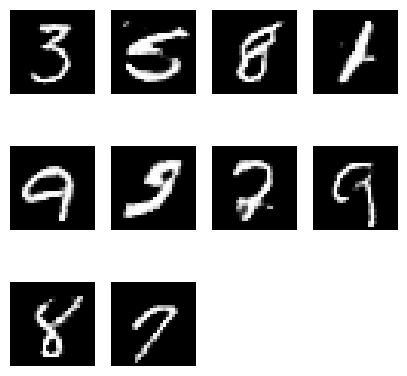

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5207 - g_loss: 1.3252
Epoch 67/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5212 - g_loss: 1.3154

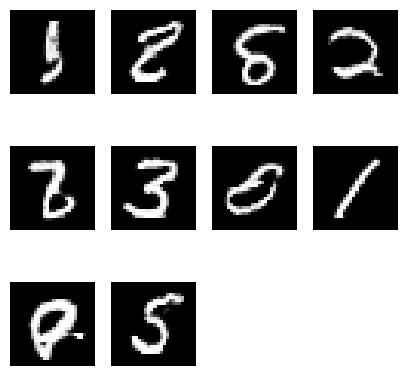

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5212 - g_loss: 1.3154
Epoch 68/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5209 - g_loss: 1.3464

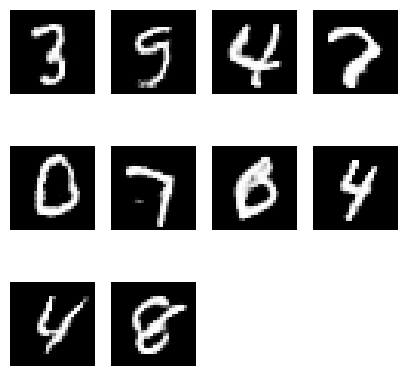

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5209 - g_loss: 1.3463
Epoch 69/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5214 - g_loss: 1.3156

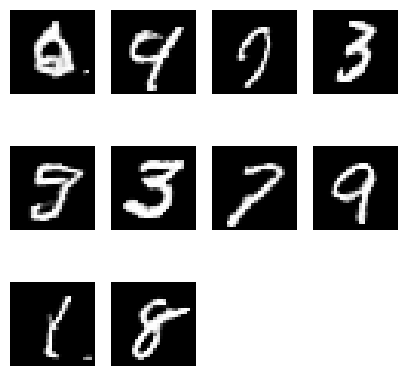

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5214 - g_loss: 1.3156
Epoch 70/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5186 - g_loss: 1.3053

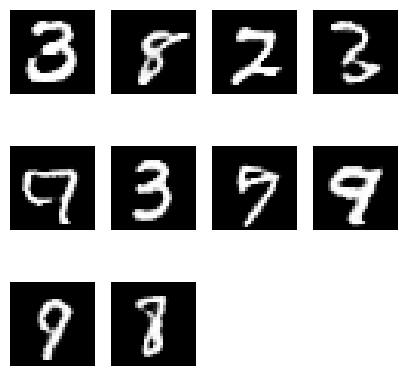

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5186 - g_loss: 1.3053
Epoch 71/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5228 - g_loss: 1.3234

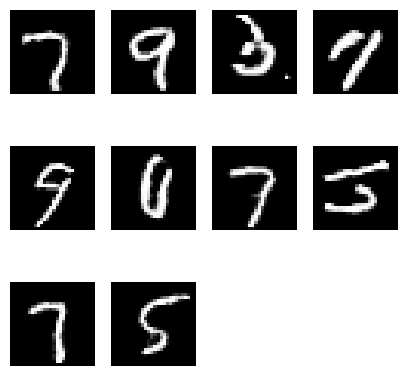

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5228 - g_loss: 1.3234
Epoch 72/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5237 - g_loss: 1.3348

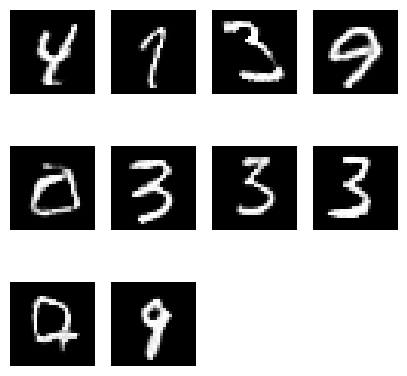

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5237 - g_loss: 1.3348
Epoch 73/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.5199 - g_loss: 1.3382

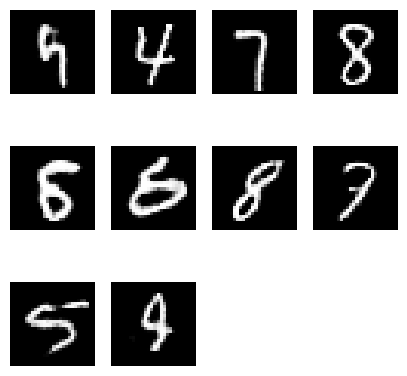

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5199 - g_loss: 1.3381
Epoch 74/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5256 - g_loss: 1.3215

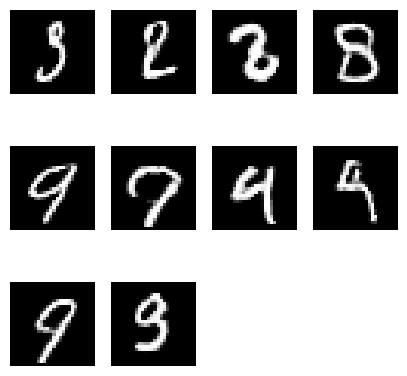

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5256 - g_loss: 1.3215
Epoch 75/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5200 - g_loss: 1.3129

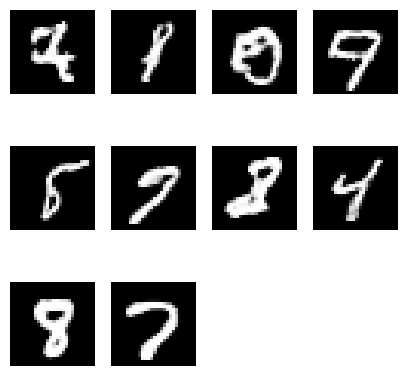

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5200 - g_loss: 1.3128
Epoch 76/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5197 - g_loss: 1.3032

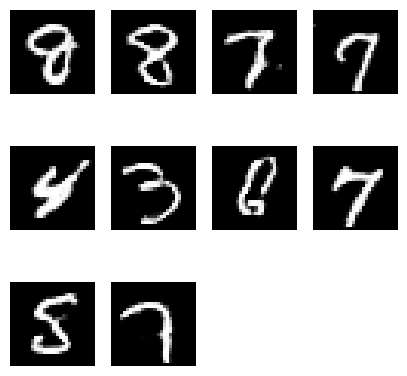

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5197 - g_loss: 1.3032
Epoch 77/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5153 - g_loss: 1.3259

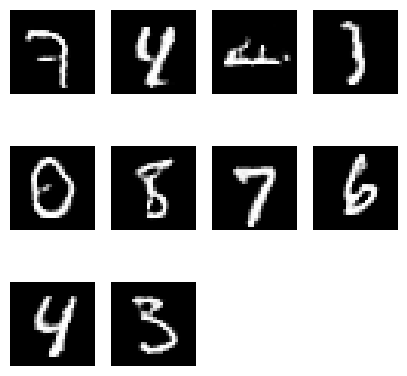

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5153 - g_loss: 1.3258
Epoch 78/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5210 - g_loss: 1.3562

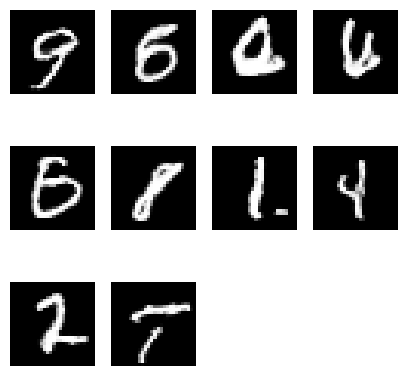

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5210 - g_loss: 1.3561
Epoch 79/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5194 - g_loss: 1.3198

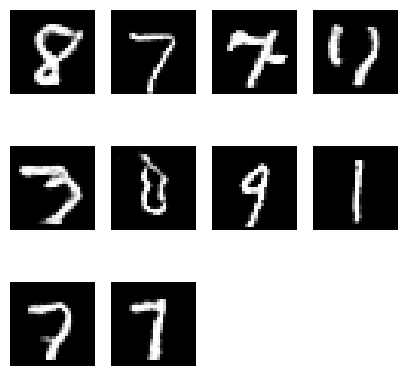

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5194 - g_loss: 1.3198
Epoch 80/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5215 - g_loss: 1.3291

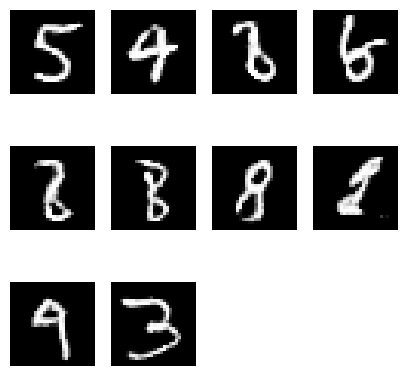

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5215 - g_loss: 1.3290
Epoch 81/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5213 - g_loss: 1.3213

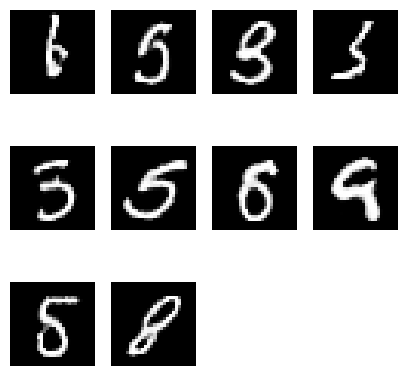

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5212 - g_loss: 1.3213
Epoch 82/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5140 - g_loss: 1.3164

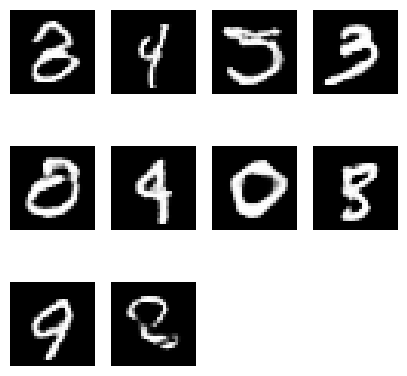

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5140 - g_loss: 1.3164
Epoch 83/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5231 - g_loss: 1.3369

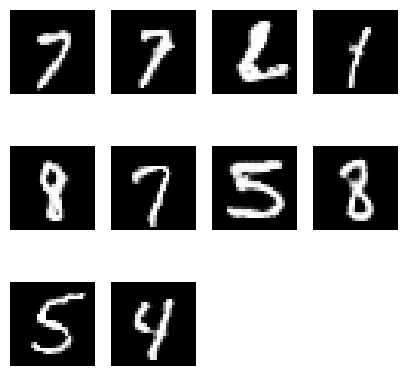

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5231 - g_loss: 1.3368
Epoch 84/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5142 - g_loss: 1.2992

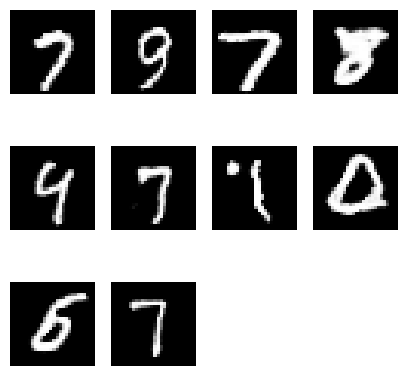

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5142 - g_loss: 1.2992
Epoch 85/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5160 - g_loss: 1.3360

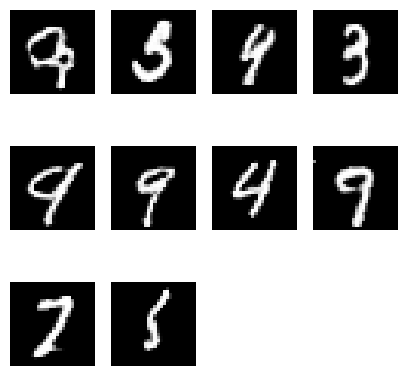

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5160 - g_loss: 1.3359
Epoch 86/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5189 - g_loss: 1.3207

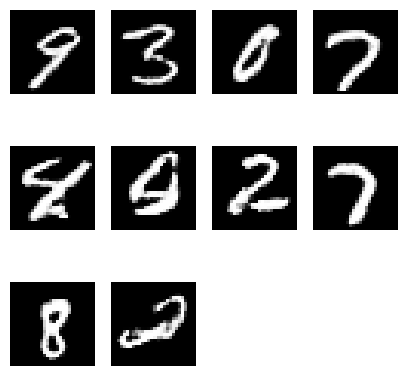

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5189 - g_loss: 1.3207
Epoch 87/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5176 - g_loss: 1.3134

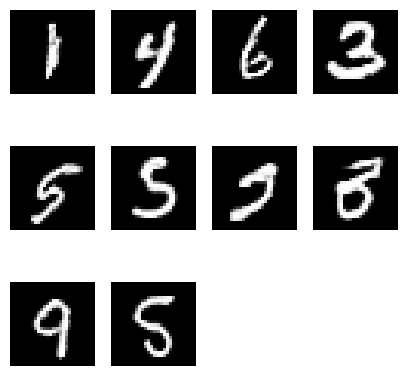

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5177 - g_loss: 1.3134
Epoch 88/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5160 - g_loss: 1.3286

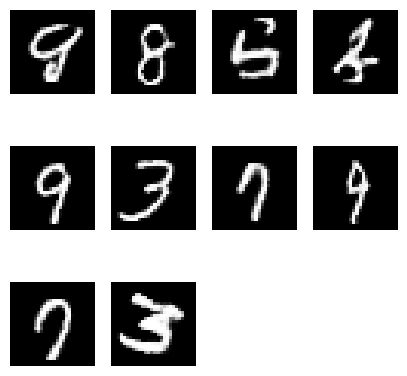

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5160 - g_loss: 1.3286
Epoch 89/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5214 - g_loss: 1.3432

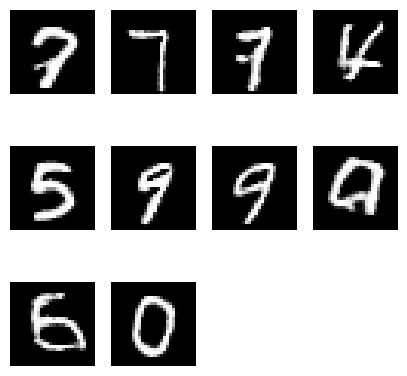

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5214 - g_loss: 1.3432
Epoch 90/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5203 - g_loss: 1.3145

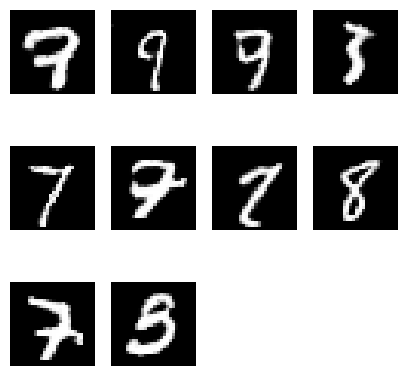

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5203 - g_loss: 1.3145
Epoch 91/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5179 - g_loss: 1.3146

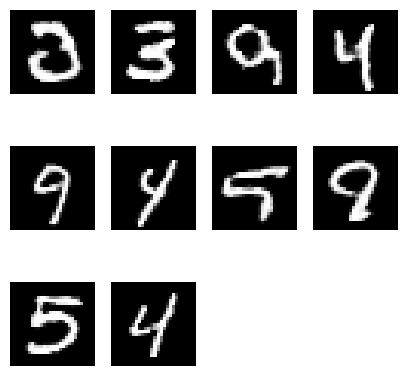

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5179 - g_loss: 1.3145
Epoch 92/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5179 - g_loss: 1.3323

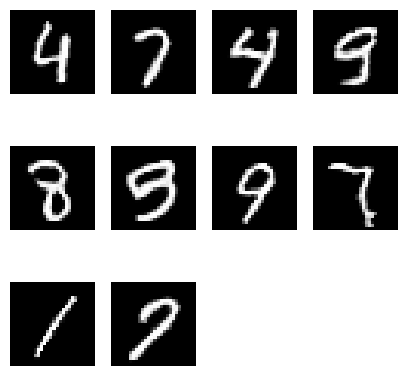

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5179 - g_loss: 1.3323
Epoch 93/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5180 - g_loss: 1.3183

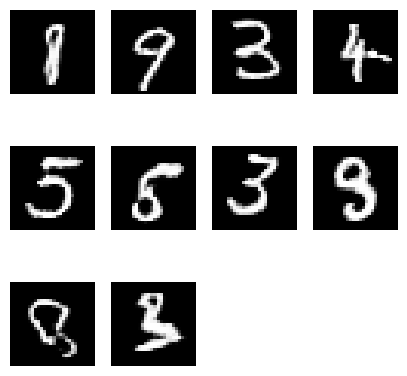

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5180 - g_loss: 1.3182
Epoch 94/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5155 - g_loss: 1.3157

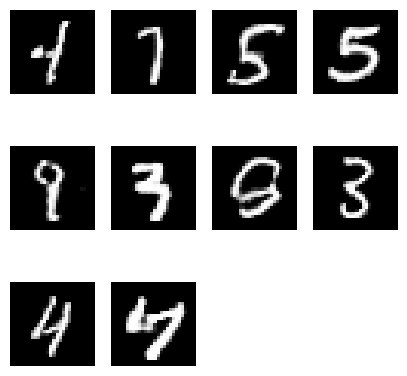

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5155 - g_loss: 1.3157
Epoch 95/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5168 - g_loss: 1.3343

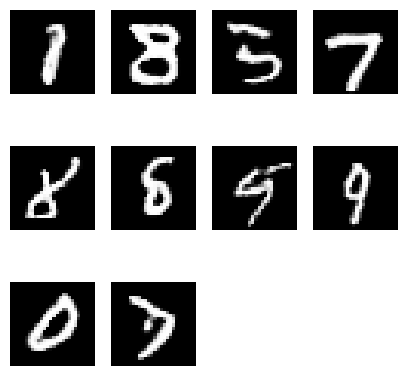

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5168 - g_loss: 1.3342
Epoch 96/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5176 - g_loss: 1.3299

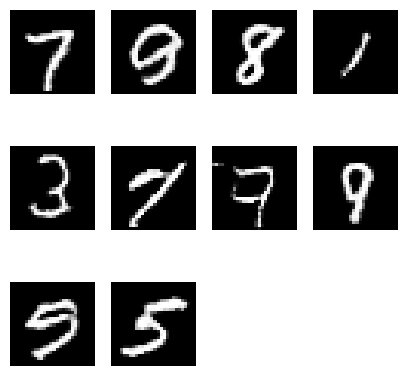

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5176 - g_loss: 1.3299
Epoch 97/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5169 - g_loss: 1.3354

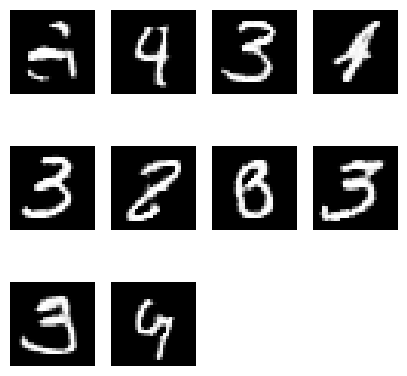

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5169 - g_loss: 1.3354
Epoch 98/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5179 - g_loss: 1.3124

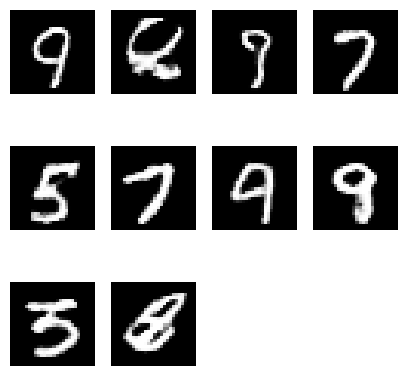

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5179 - g_loss: 1.3124
Epoch 99/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5192 - g_loss: 1.3236

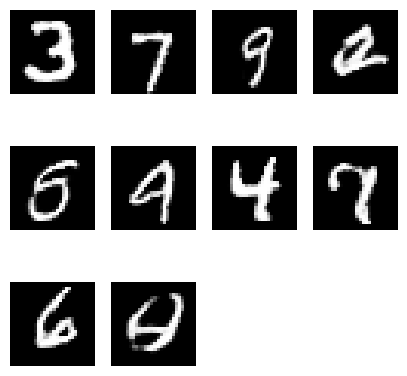

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5192 - g_loss: 1.3235
Epoch 100/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5173 - g_loss: 1.3178

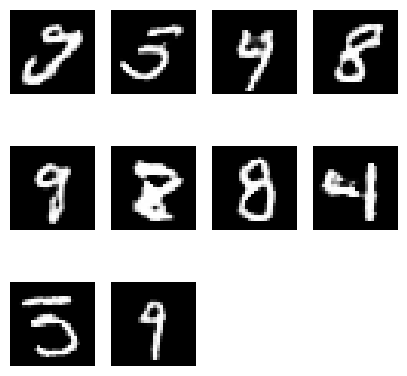

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5173 - g_loss: 1.3178
Epoch 101/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5190 - g_loss: 1.3248

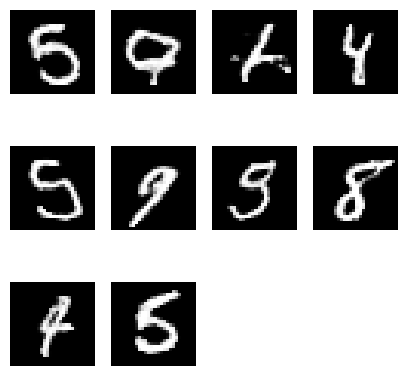

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5190 - g_loss: 1.3247
Epoch 102/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5140 - g_loss: 1.3150

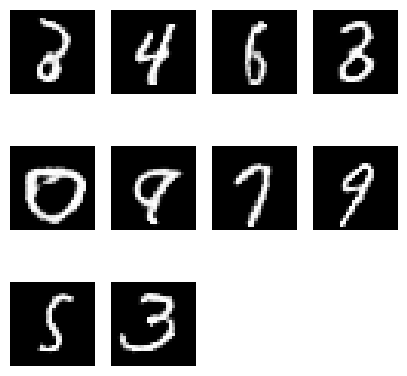

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5140 - g_loss: 1.3150
Epoch 103/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5153 - g_loss: 1.3471

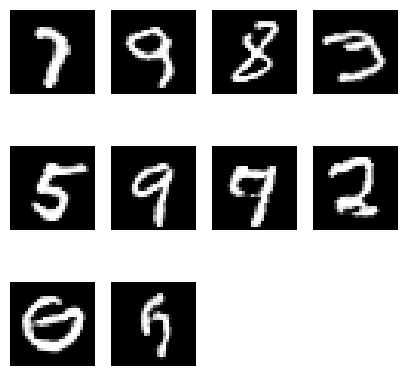

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5153 - g_loss: 1.3470
Epoch 104/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5131 - g_loss: 1.3273

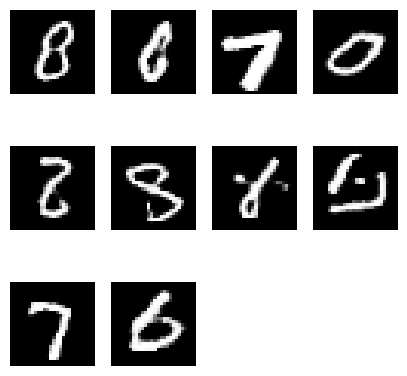

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5131 - g_loss: 1.3273
Epoch 105/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5159 - g_loss: 1.3475

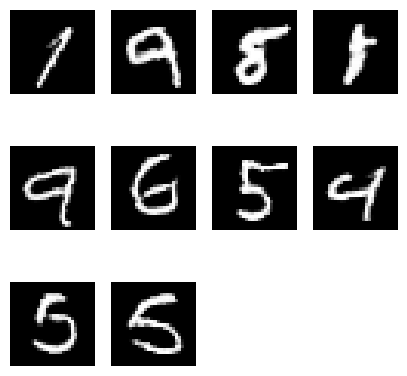

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5159 - g_loss: 1.3475
Epoch 106/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5152 - g_loss: 1.3368

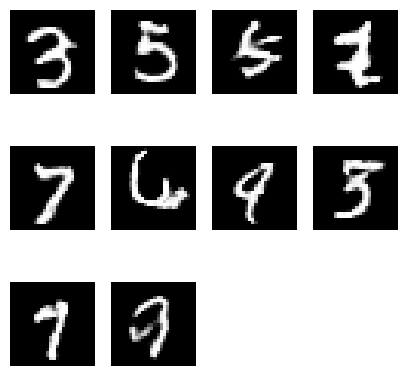

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5152 - g_loss: 1.3368
Epoch 107/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5169 - g_loss: 1.3286

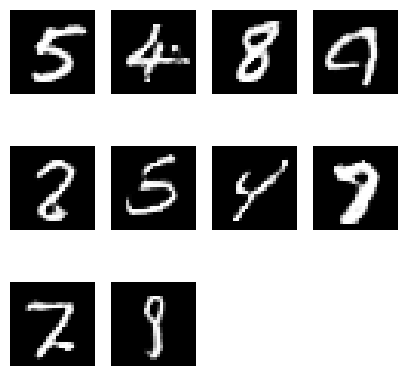

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5169 - g_loss: 1.3285
Epoch 108/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5165 - g_loss: 1.3352

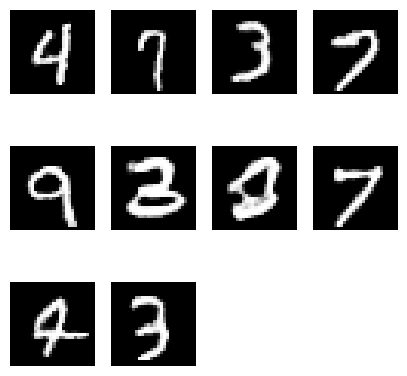

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5165 - g_loss: 1.3351
Epoch 109/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5167 - g_loss: 1.3266

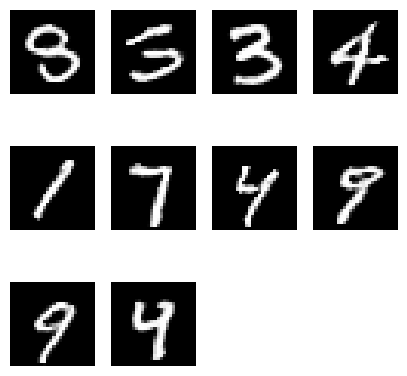

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5167 - g_loss: 1.3266
Epoch 110/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5163 - g_loss: 1.3285

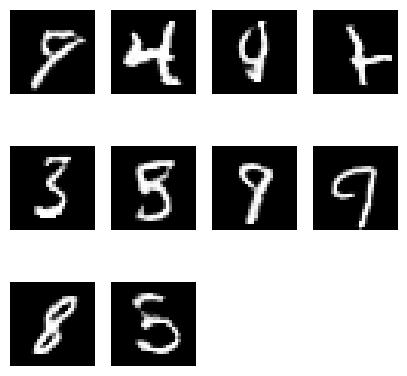

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5163 - g_loss: 1.3285
Epoch 111/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5168 - g_loss: 1.3494

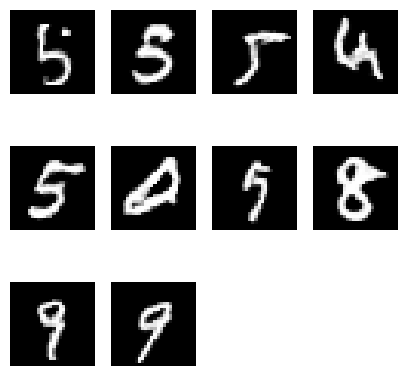

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5168 - g_loss: 1.3493
Epoch 112/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5150 - g_loss: 1.3180

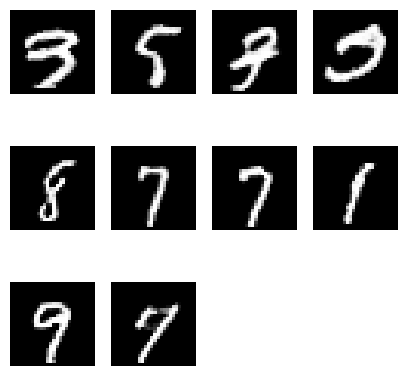

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5150 - g_loss: 1.3179
Epoch 113/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5139 - g_loss: 1.3177

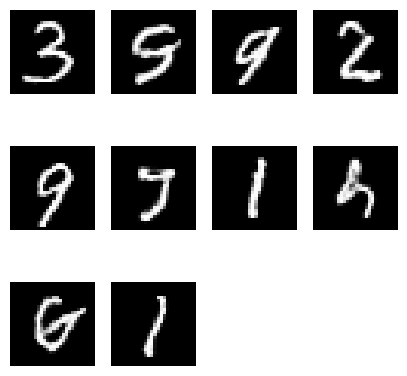

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5139 - g_loss: 1.3177
Epoch 114/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5165 - g_loss: 1.3342

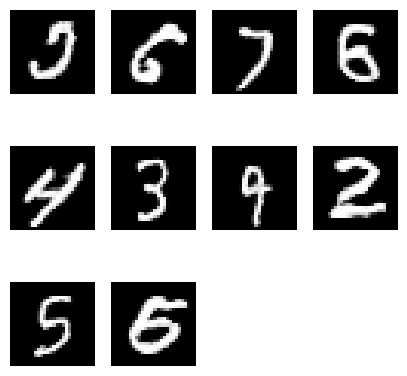

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5165 - g_loss: 1.3342
Epoch 115/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5123 - g_loss: 1.3338

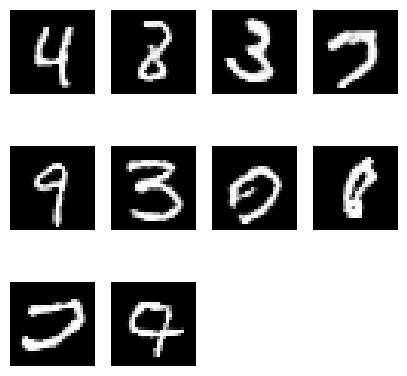

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5123 - g_loss: 1.3338
Epoch 116/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5189 - g_loss: 1.3400

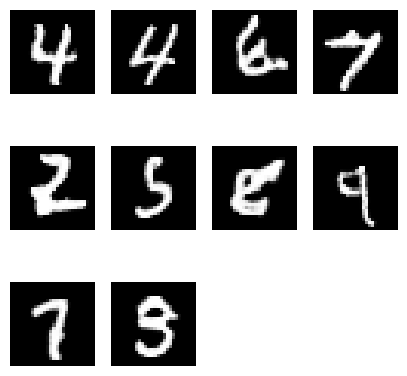

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5189 - g_loss: 1.3400
Epoch 117/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5134 - g_loss: 1.3139

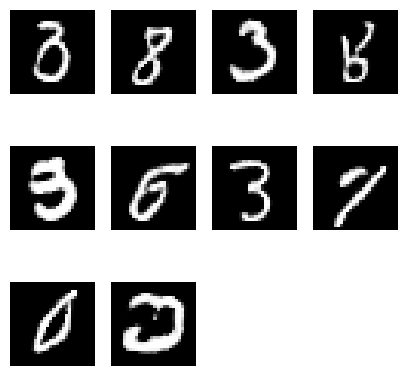

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5134 - g_loss: 1.3139
Epoch 118/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5110 - g_loss: 1.3227

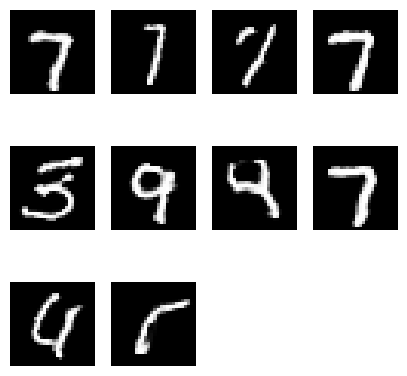

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5110 - g_loss: 1.3227
Epoch 119/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5181 - g_loss: 1.3488

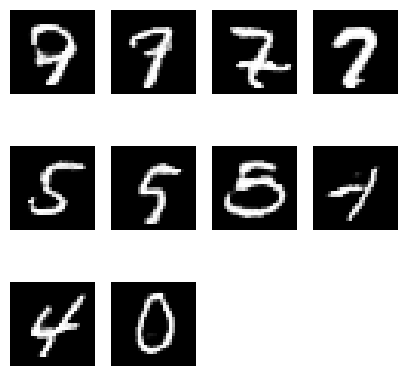

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5181 - g_loss: 1.3488
Epoch 120/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5161 - g_loss: 1.3440

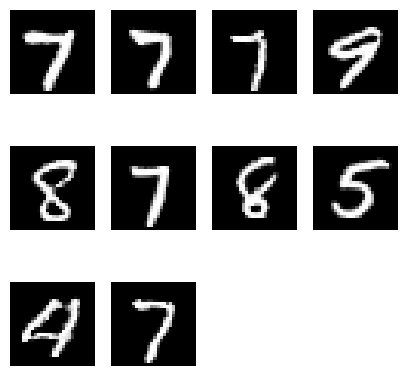

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5161 - g_loss: 1.3439
Epoch 121/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5178 - g_loss: 1.3200

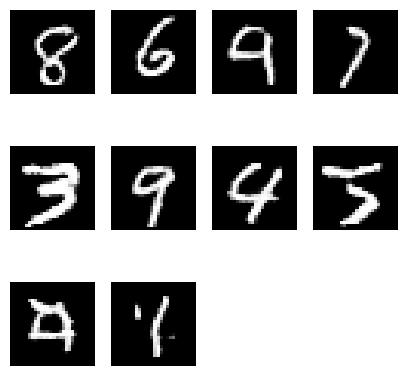

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5178 - g_loss: 1.3200
Epoch 122/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5118 - g_loss: 1.3416

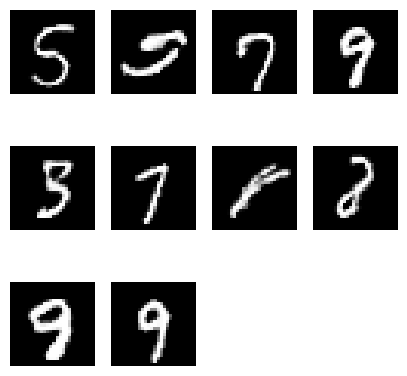

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5118 - g_loss: 1.3415
Epoch 123/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5117 - g_loss: 1.3432

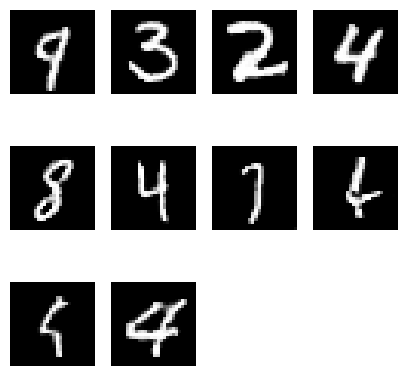

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5117 - g_loss: 1.3432
Epoch 124/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5122 - g_loss: 1.3223

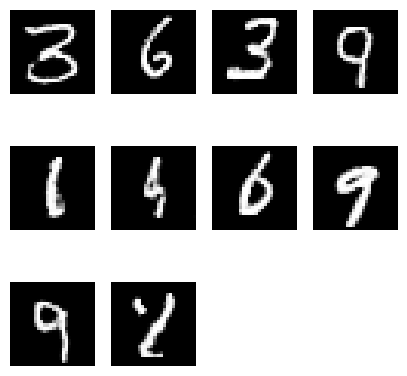

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5122 - g_loss: 1.3223
Epoch 125/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5163 - g_loss: 1.3463

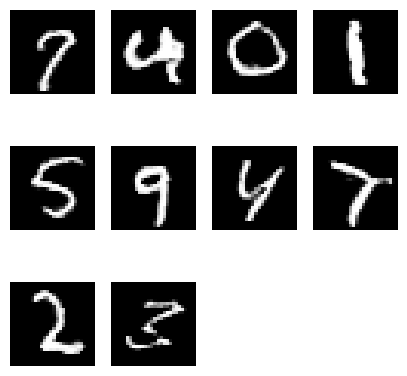

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5163 - g_loss: 1.3462
Epoch 126/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5142 - g_loss: 1.3773

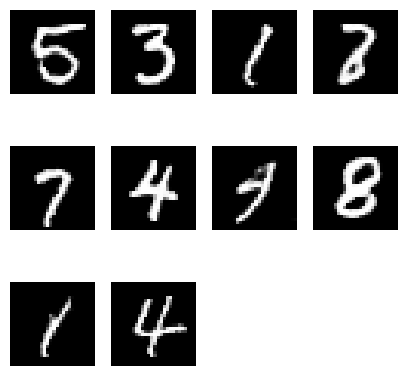

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5142 - g_loss: 1.3772
Epoch 127/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5124 - g_loss: 1.3270

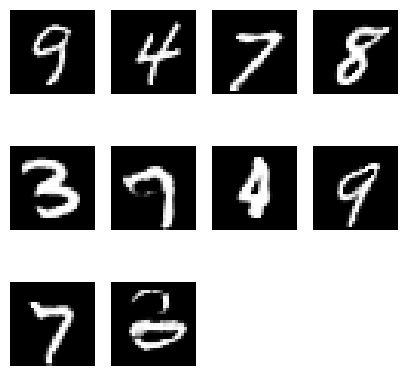

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5124 - g_loss: 1.3270
Epoch 128/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5118 - g_loss: 1.3225

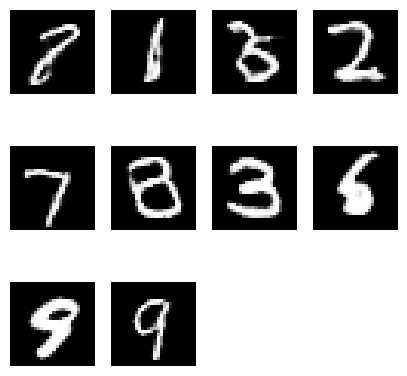

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5118 - g_loss: 1.3225
Epoch 129/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5130 - g_loss: 1.3326

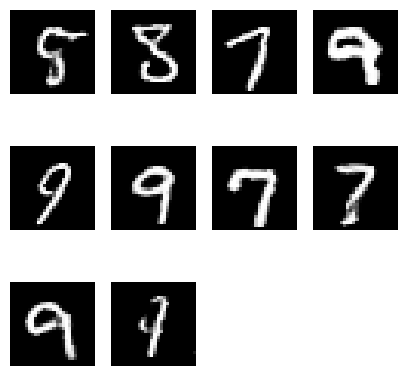

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5130 - g_loss: 1.3325
Epoch 130/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5146 - g_loss: 1.3859

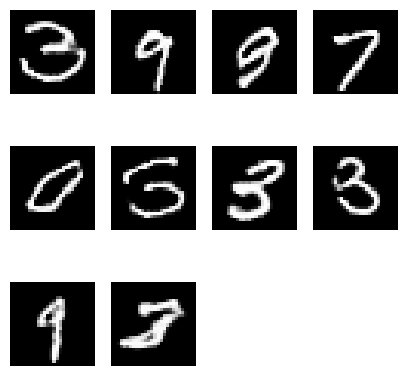

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5146 - g_loss: 1.3858
Epoch 131/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5140 - g_loss: 1.3560

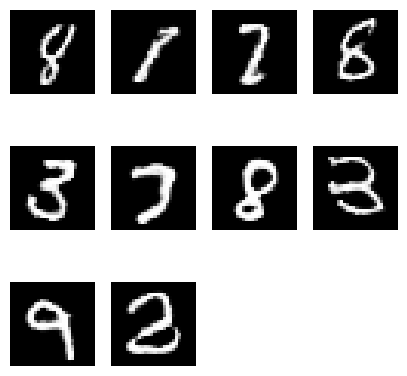

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5140 - g_loss: 1.3559
Epoch 132/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5137 - g_loss: 1.3473

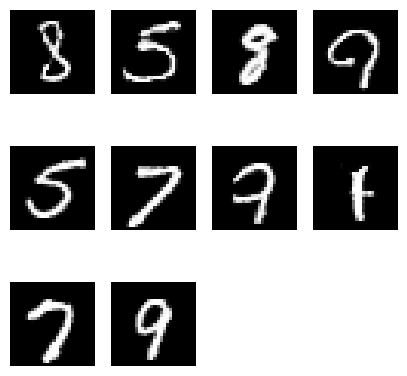

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5137 - g_loss: 1.3473
Epoch 133/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5117 - g_loss: 1.3279

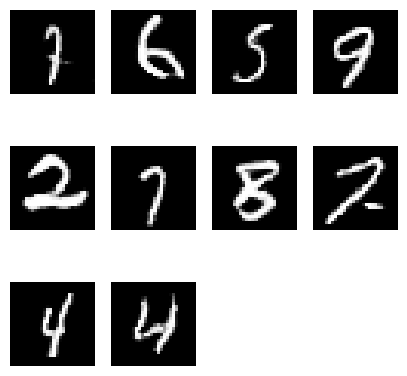

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5117 - g_loss: 1.3279
Epoch 134/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5135 - g_loss: 1.3495

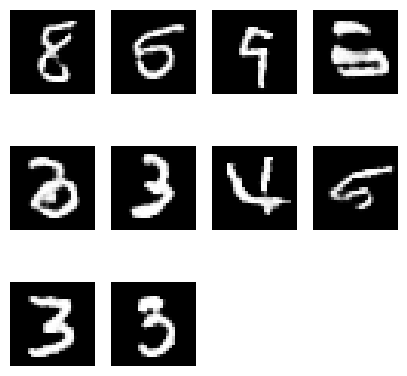

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5135 - g_loss: 1.3495
Epoch 135/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5145 - g_loss: 1.3485

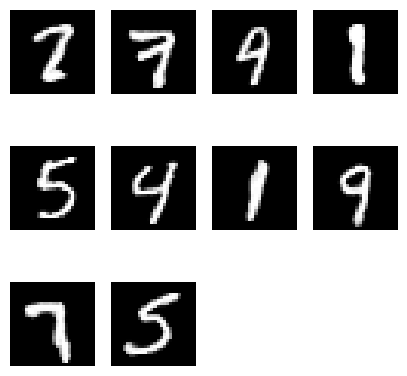

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5145 - g_loss: 1.3485
Epoch 136/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5124 - g_loss: 1.3391

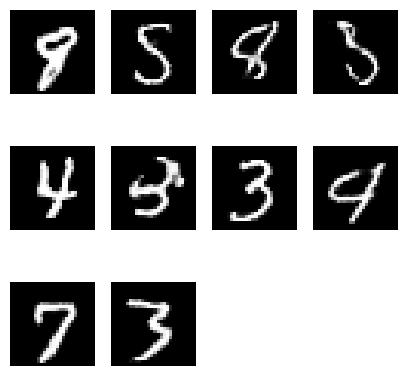

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5124 - g_loss: 1.3391
Epoch 137/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5163 - g_loss: 1.3557

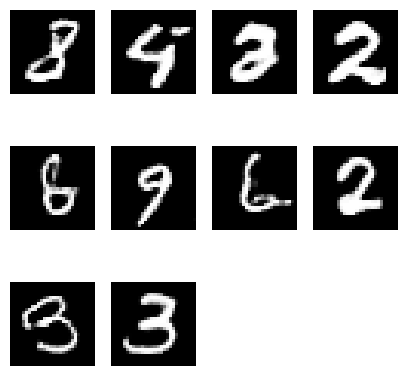

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5163 - g_loss: 1.3557
Epoch 138/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5101 - g_loss: 1.3541

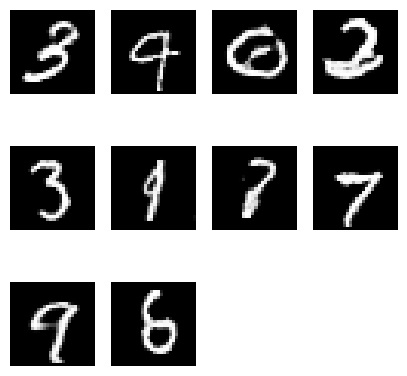

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5101 - g_loss: 1.3541
Epoch 139/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5092 - g_loss: 1.3307

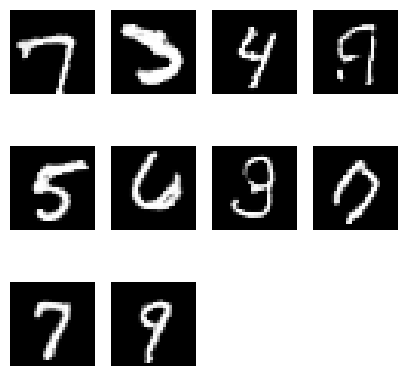

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5092 - g_loss: 1.3307
Epoch 140/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5120 - g_loss: 1.3408

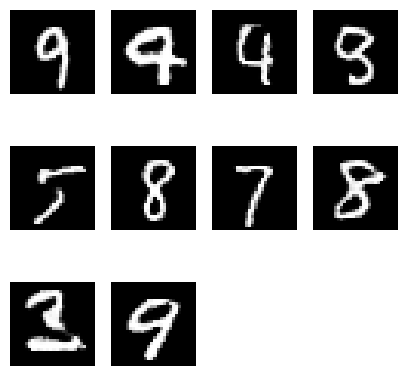

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5120 - g_loss: 1.3408
Epoch 141/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5163 - g_loss: 1.3572

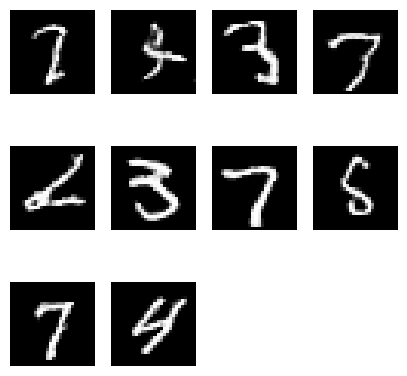

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5163 - g_loss: 1.3572
Epoch 142/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5086 - g_loss: 1.3687

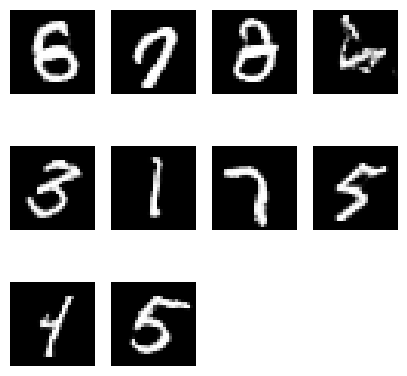

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.5086 - g_loss: 1.3686
Epoch 143/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5105 - g_loss: 1.3257

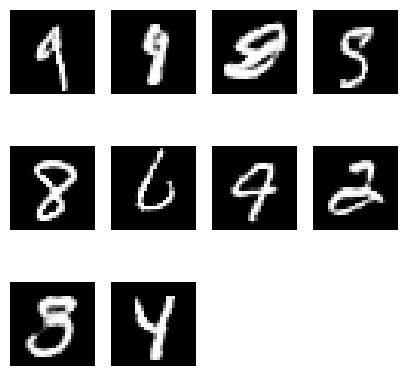

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5105 - g_loss: 1.3257
Epoch 144/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5124 - g_loss: 1.3580

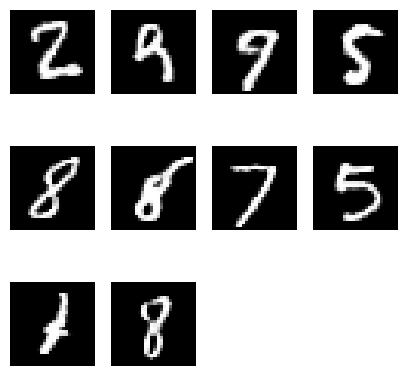

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5124 - g_loss: 1.3580
Epoch 145/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5126 - g_loss: 1.3370

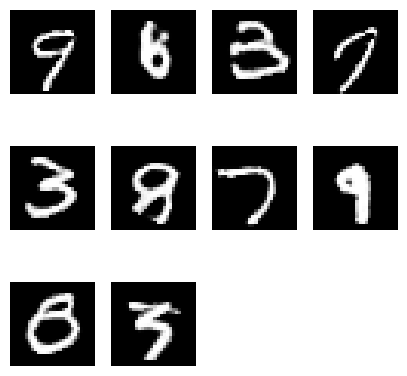

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5126 - g_loss: 1.3370
Epoch 146/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5146 - g_loss: 1.3531

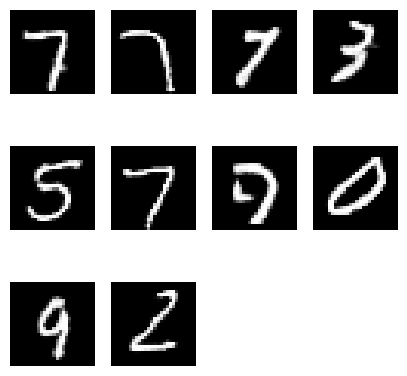

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5146 - g_loss: 1.3530
Epoch 147/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5104 - g_loss: 1.3527

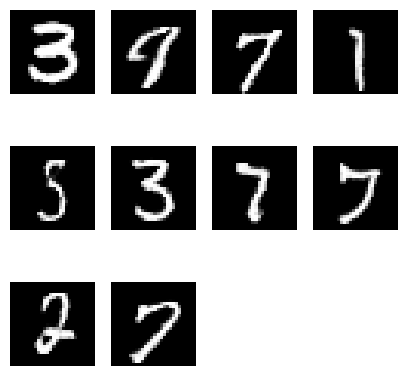

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5104 - g_loss: 1.3527
Epoch 148/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5143 - g_loss: 1.3542

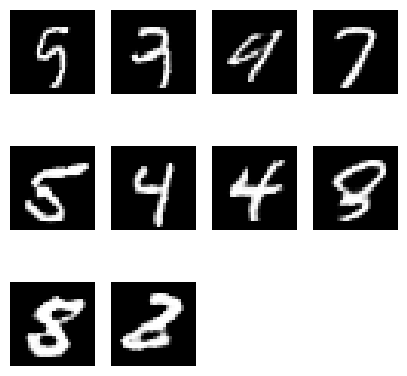

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5143 - g_loss: 1.3542
Epoch 149/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5097 - g_loss: 1.3346

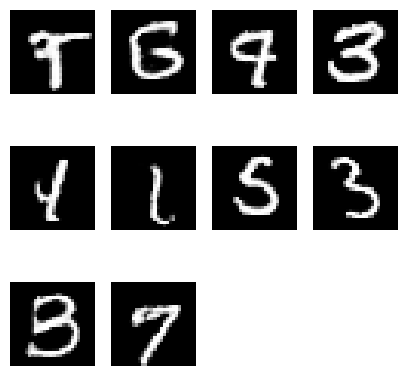

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5097 - g_loss: 1.3345
Epoch 150/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5135 - g_loss: 1.3435

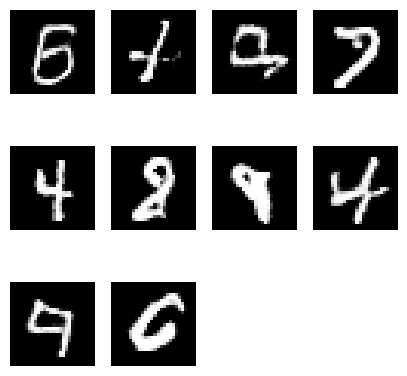

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5135 - g_loss: 1.3435
Epoch 151/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5109 - g_loss: 1.3586

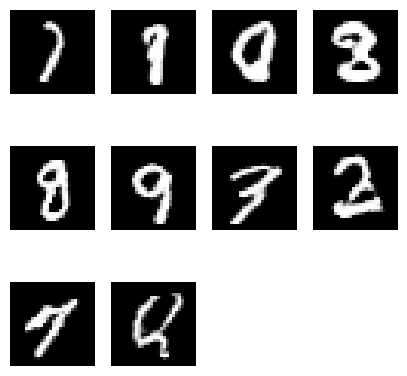

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5109 - g_loss: 1.3585
Epoch 152/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5090 - g_loss: 1.3548

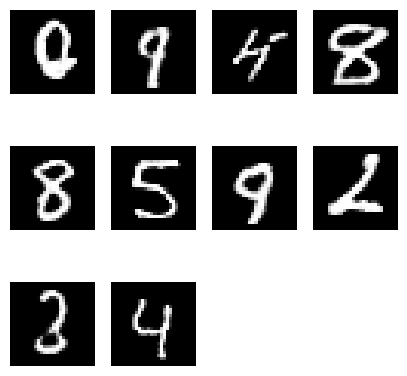

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5090 - g_loss: 1.3548
Epoch 153/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5136 - g_loss: 1.3567

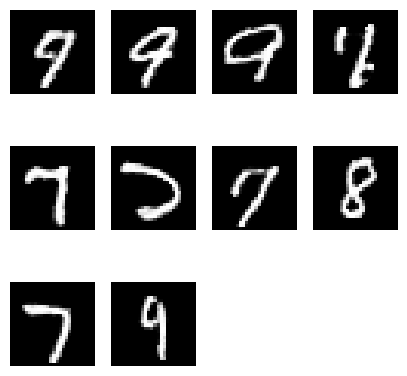

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5136 - g_loss: 1.3567
Epoch 154/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5094 - g_loss: 1.3649

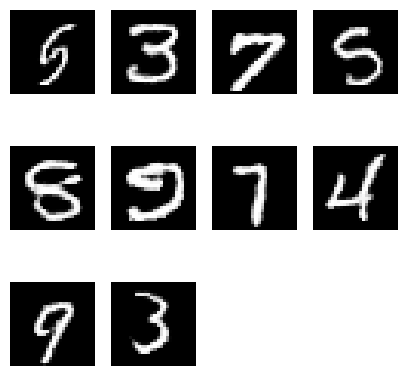

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5094 - g_loss: 1.3649
Epoch 155/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5093 - g_loss: 1.3475

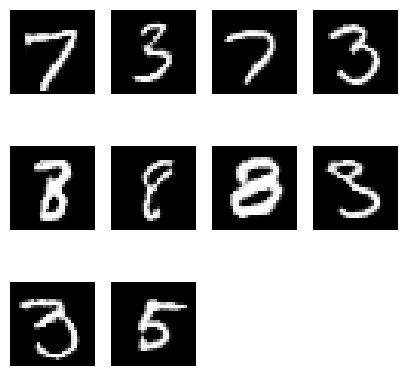

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5093 - g_loss: 1.3475
Epoch 156/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5095 - g_loss: 1.3716

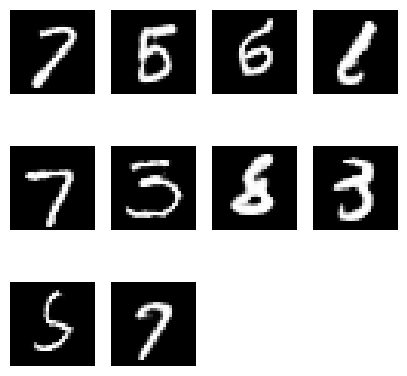

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5095 - g_loss: 1.3716
Epoch 157/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5179 - g_loss: 1.3519

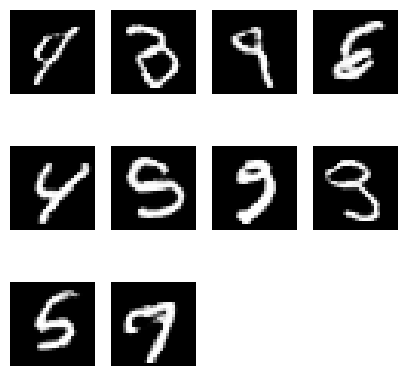

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5178 - g_loss: 1.3519
Epoch 158/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5113 - g_loss: 1.3551

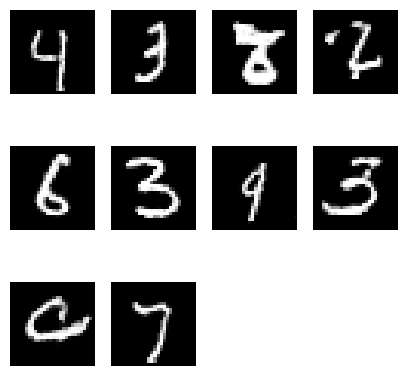

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5113 - g_loss: 1.3550
Epoch 159/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5106 - g_loss: 1.3591

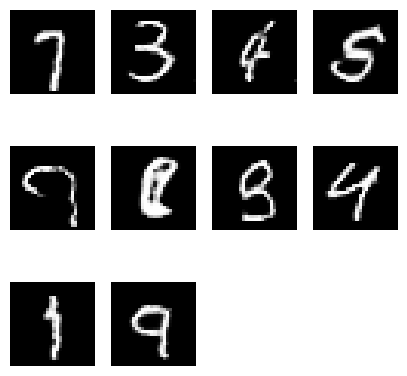

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5106 - g_loss: 1.3590
Epoch 160/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5099 - g_loss: 1.3509

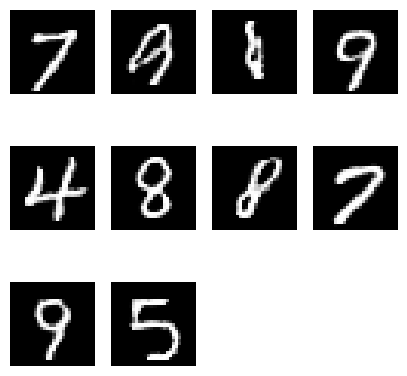

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5099 - g_loss: 1.3509
Epoch 161/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5091 - g_loss: 1.3561

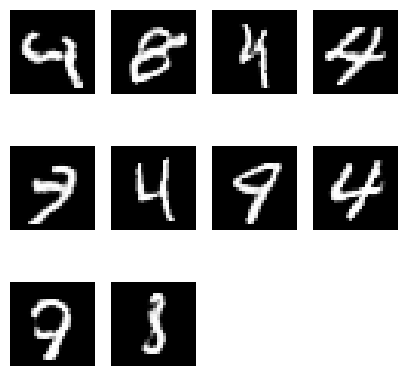

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5091 - g_loss: 1.3560
Epoch 162/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5084 - g_loss: 1.3533

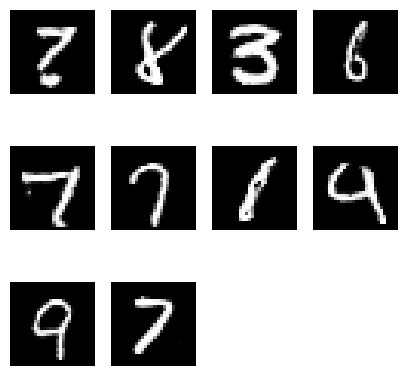

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5084 - g_loss: 1.3533
Epoch 163/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5112 - g_loss: 1.3713

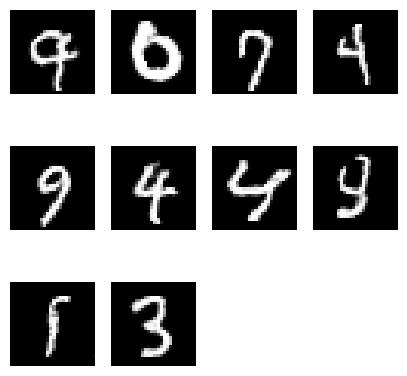

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5112 - g_loss: 1.3713
Epoch 164/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5107 - g_loss: 1.3641

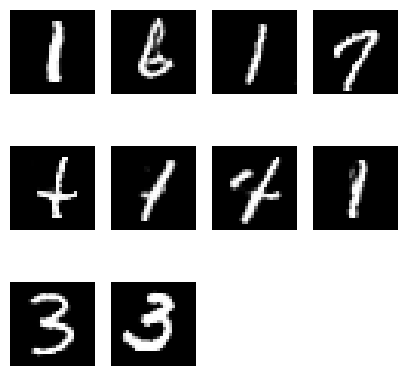

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5107 - g_loss: 1.3640
Epoch 165/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5085 - g_loss: 1.3579

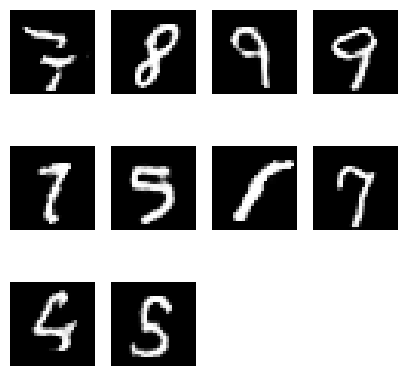

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5085 - g_loss: 1.3579
Epoch 166/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5123 - g_loss: 1.3700

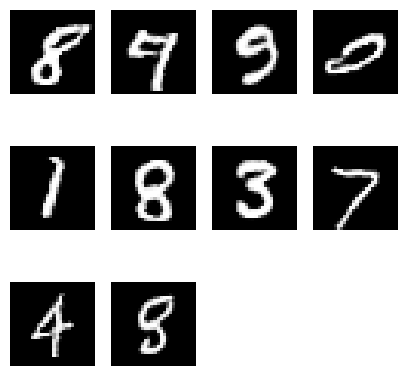

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5123 - g_loss: 1.3700
Epoch 167/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5118 - g_loss: 1.3433

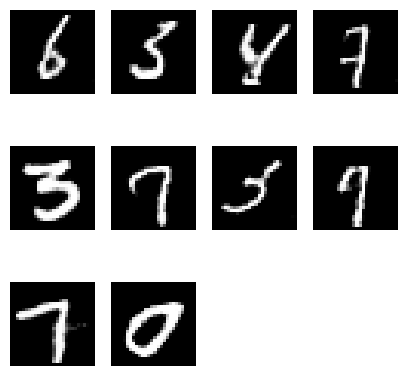

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5118 - g_loss: 1.3433
Epoch 168/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5077 - g_loss: 1.3505

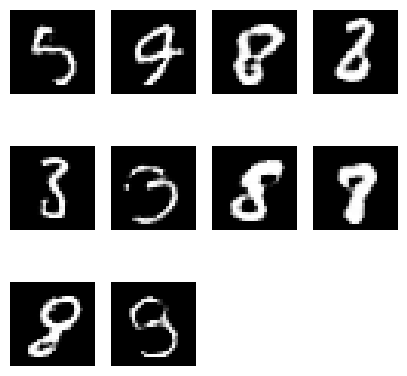

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5077 - g_loss: 1.3505
Epoch 169/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5095 - g_loss: 1.3811

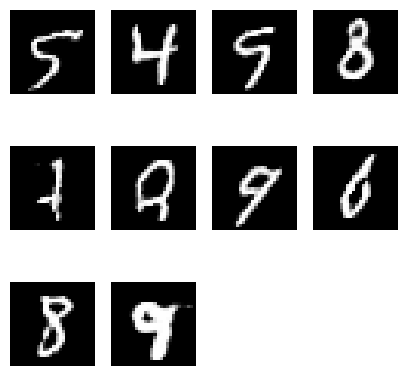

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5095 - g_loss: 1.3810
Epoch 170/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5073 - g_loss: 1.3578

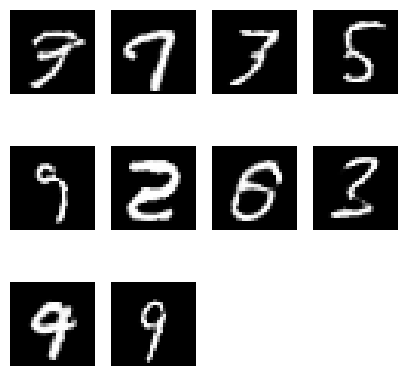

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5073 - g_loss: 1.3578
Epoch 171/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5067 - g_loss: 1.3574

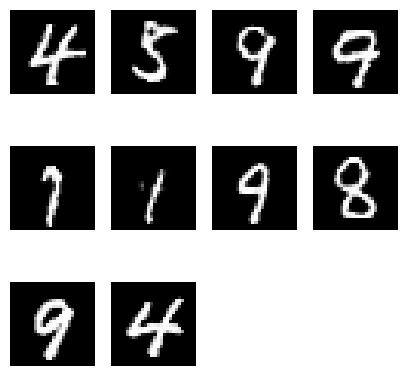

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5067 - g_loss: 1.3574
Epoch 172/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5089 - g_loss: 1.3729

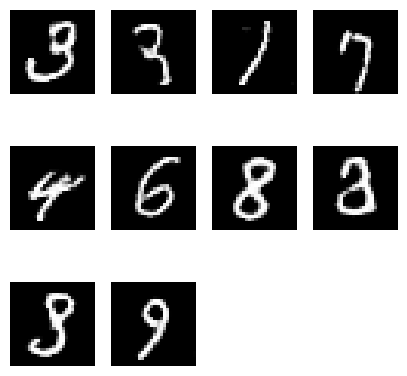

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5089 - g_loss: 1.3729
Epoch 173/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5086 - g_loss: 1.3869

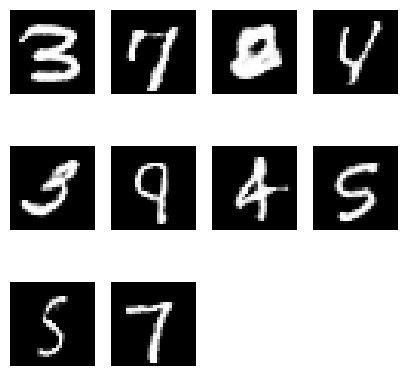

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5086 - g_loss: 1.3868
Epoch 174/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5077 - g_loss: 1.3583

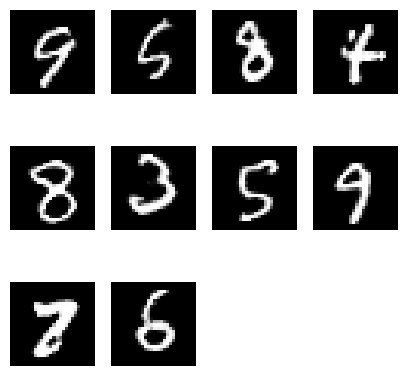

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5077 - g_loss: 1.3582
Epoch 175/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5101 - g_loss: 1.3751

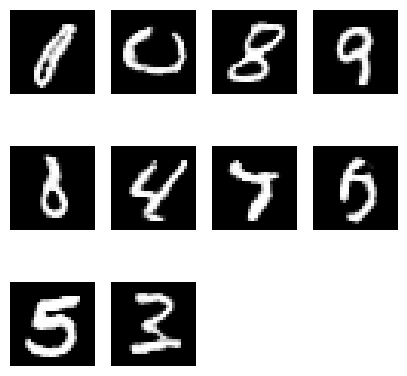

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - d_loss: 0.5101 - g_loss: 1.3751
Epoch 176/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5079 - g_loss: 1.3477

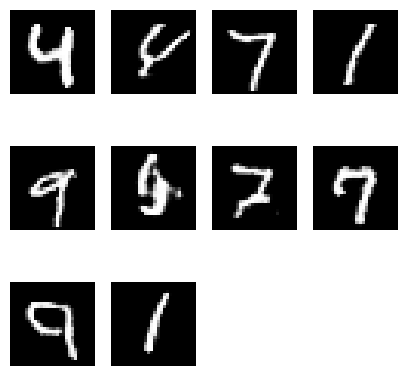

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5079 - g_loss: 1.3477
Epoch 177/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5112 - g_loss: 1.3852

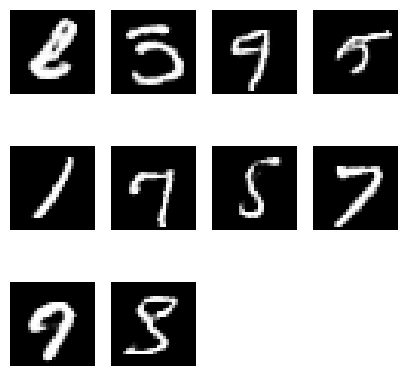

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5112 - g_loss: 1.3852
Epoch 178/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5057 - g_loss: 1.3681

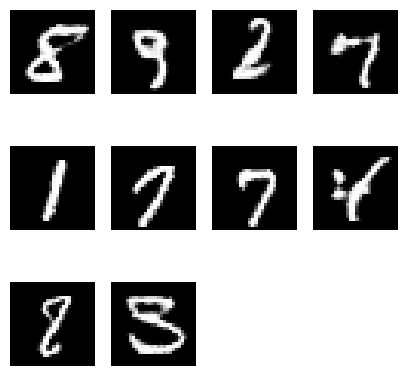

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5057 - g_loss: 1.3681
Epoch 179/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5086 - g_loss: 1.3676

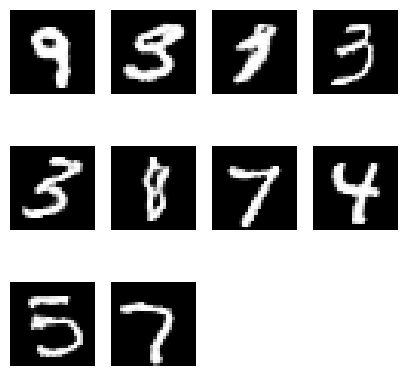

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5086 - g_loss: 1.3676
Epoch 180/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5065 - g_loss: 1.3653

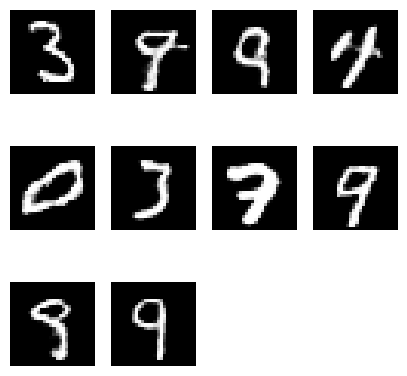

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5065 - g_loss: 1.3653
Epoch 181/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5028 - g_loss: 1.3636

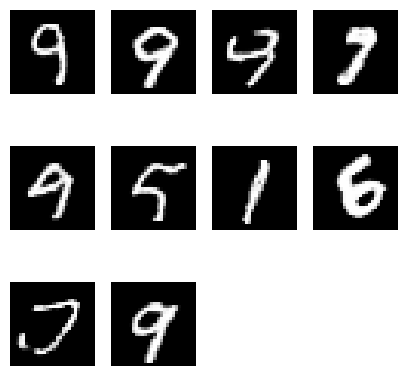

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5028 - g_loss: 1.3636
Epoch 182/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5097 - g_loss: 1.3859

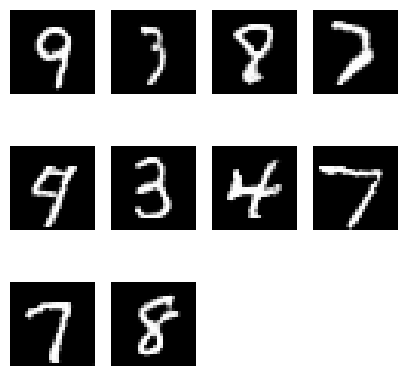

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5097 - g_loss: 1.3859
Epoch 183/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5060 - g_loss: 1.3665

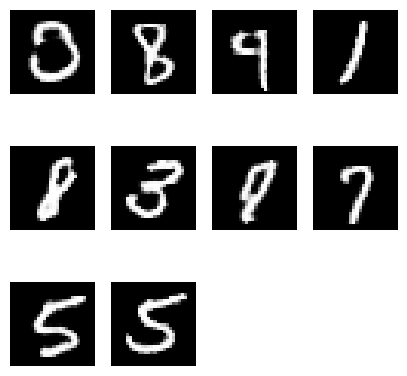

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5060 - g_loss: 1.3665
Epoch 184/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5110 - g_loss: 1.3881

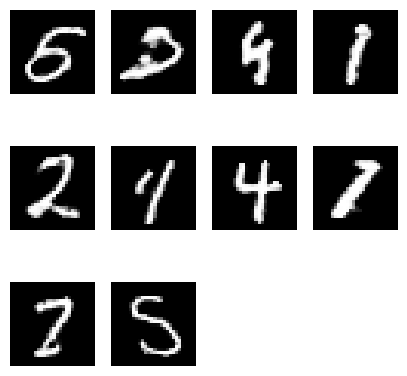

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5110 - g_loss: 1.3880
Epoch 185/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5079 - g_loss: 1.3803

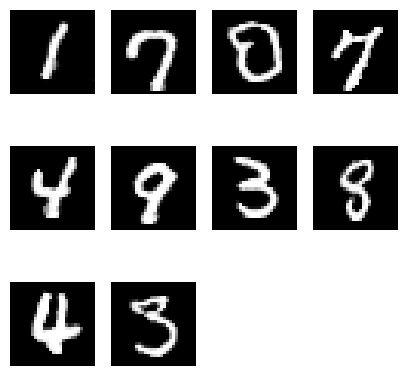

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5079 - g_loss: 1.3802
Epoch 186/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5124 - g_loss: 1.3778

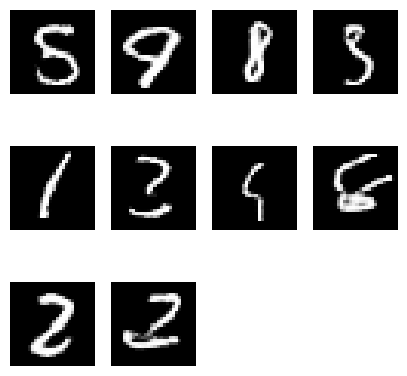

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5124 - g_loss: 1.3778
Epoch 187/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5072 - g_loss: 1.3729

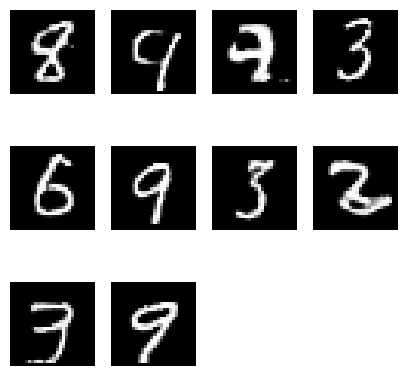

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5072 - g_loss: 1.3729
Epoch 188/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5078 - g_loss: 1.3602

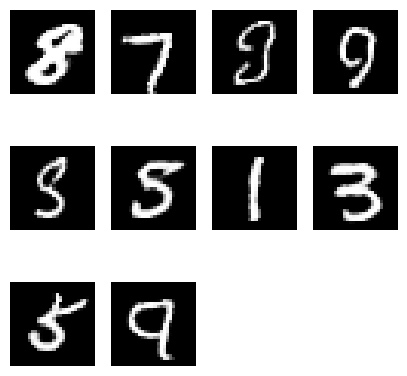

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5078 - g_loss: 1.3602
Epoch 189/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5051 - g_loss: 1.3756

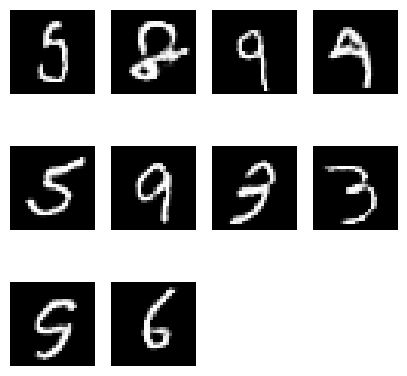

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5051 - g_loss: 1.3756
Epoch 190/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5058 - g_loss: 1.3664

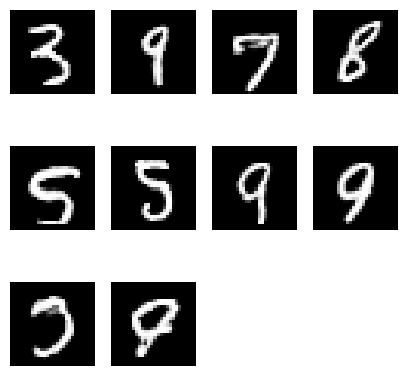

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5058 - g_loss: 1.3664
Epoch 191/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5030 - g_loss: 1.3648

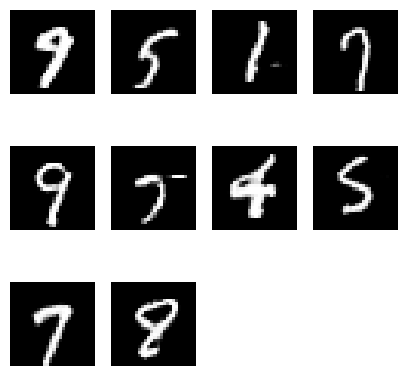

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.5030 - g_loss: 1.3648
Epoch 192/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5047 - g_loss: 1.3739

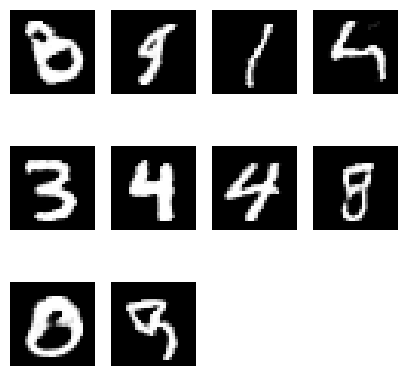

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5047 - g_loss: 1.3739
Epoch 193/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5032 - g_loss: 1.4025

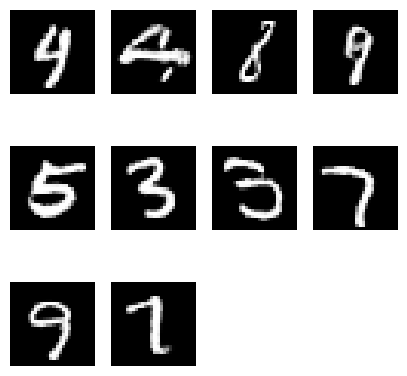

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5031 - g_loss: 1.4025
Epoch 194/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5054 - g_loss: 1.3868

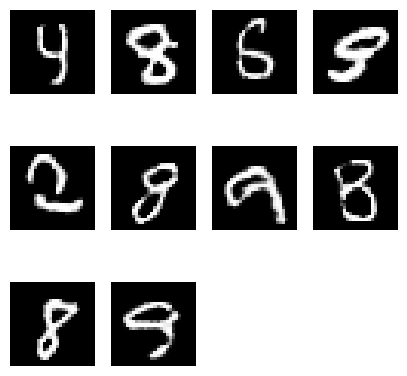

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5054 - g_loss: 1.3868
Epoch 195/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5084 - g_loss: 1.3863

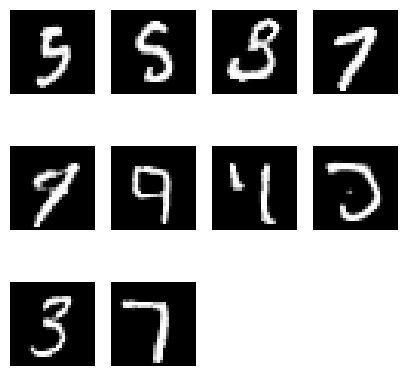

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5084 - g_loss: 1.3863
Epoch 196/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5060 - g_loss: 1.3633

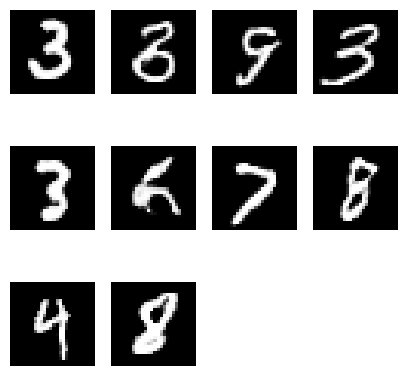

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5060 - g_loss: 1.3633
Epoch 197/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5046 - g_loss: 1.3955

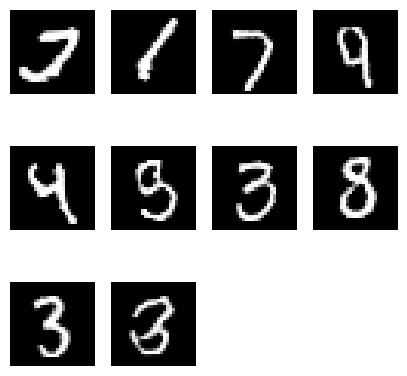

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5046 - g_loss: 1.3955
Epoch 198/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.5078 - g_loss: 1.3780

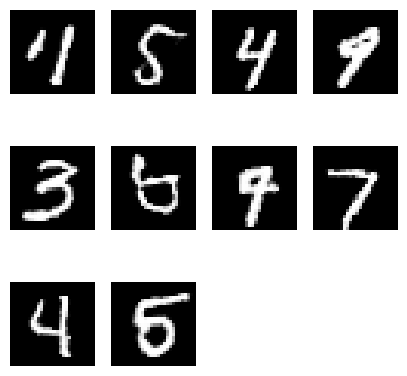

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5078 - g_loss: 1.3780
Epoch 199/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5046 - g_loss: 1.3779

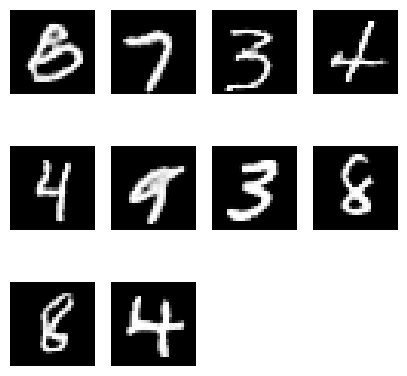

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5046 - g_loss: 1.3779
Epoch 200/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5029 - g_loss: 1.3631

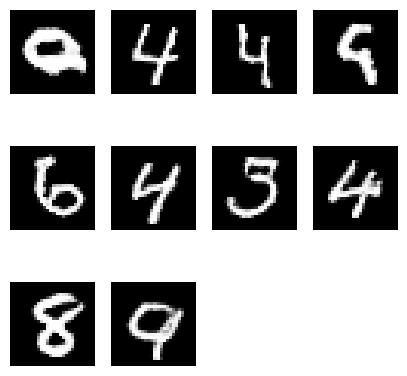

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.5029 - g_loss: 1.3631
Epoch 201/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5037 - g_loss: 1.3905

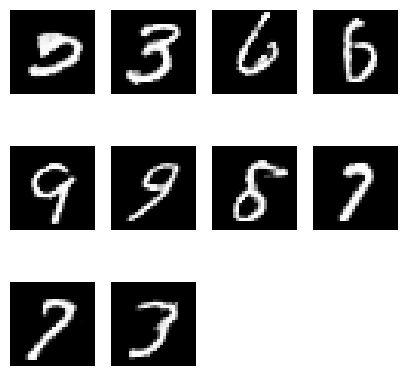

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5037 - g_loss: 1.3905
Epoch 202/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5065 - g_loss: 1.3847

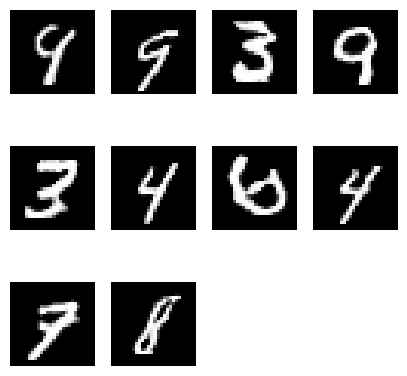

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5065 - g_loss: 1.3846
Epoch 203/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5072 - g_loss: 1.4006

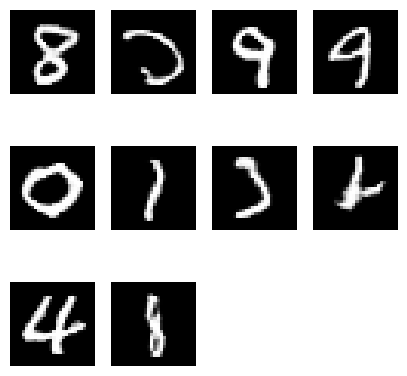

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5072 - g_loss: 1.4006
Epoch 204/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5046 - g_loss: 1.3861

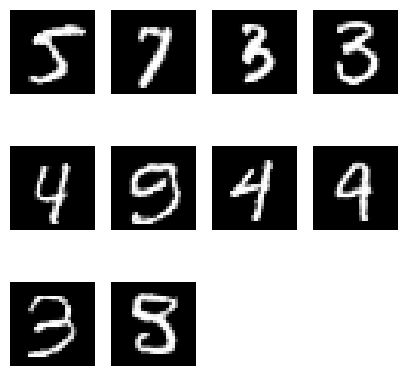

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5046 - g_loss: 1.3861
Epoch 205/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5080 - g_loss: 1.3903

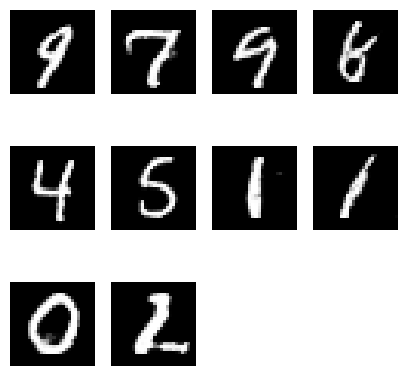

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5080 - g_loss: 1.3903
Epoch 206/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5051 - g_loss: 1.3899

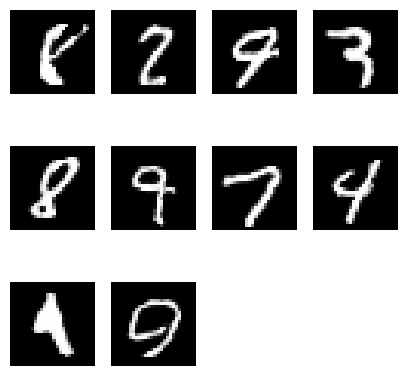

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5051 - g_loss: 1.3899
Epoch 207/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5098 - g_loss: 1.3796

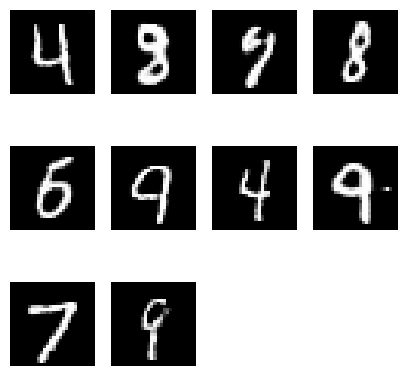

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5098 - g_loss: 1.3796
Epoch 208/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5000 - g_loss: 1.3849

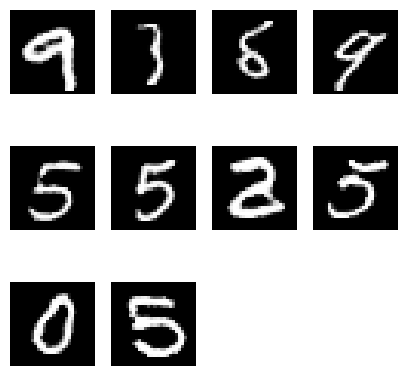

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5000 - g_loss: 1.3848
Epoch 209/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5005 - g_loss: 1.3821

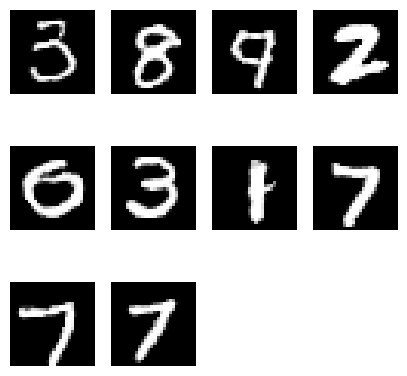

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5004 - g_loss: 1.3821
Epoch 210/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5021 - g_loss: 1.3804

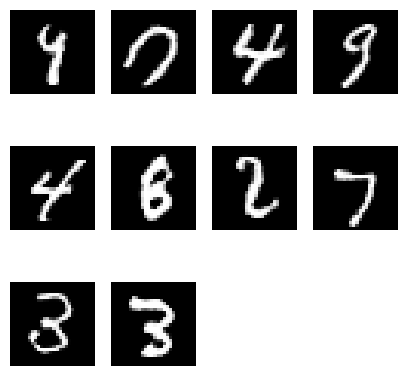

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5021 - g_loss: 1.3805
Epoch 211/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5021 - g_loss: 1.3913

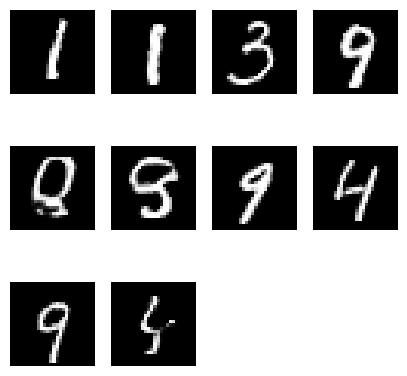

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5021 - g_loss: 1.3913
Epoch 212/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5041 - g_loss: 1.3813

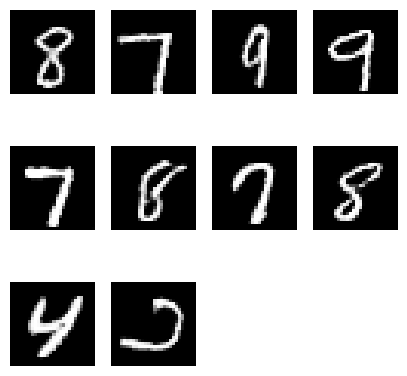

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5041 - g_loss: 1.3813
Epoch 213/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5096 - g_loss: 1.3827

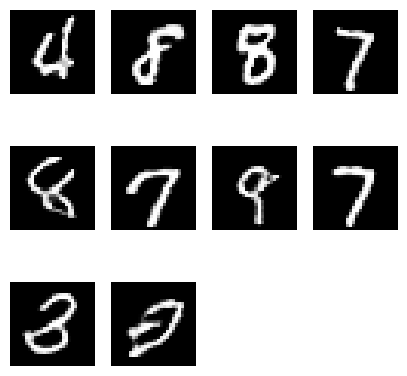

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5096 - g_loss: 1.3827
Epoch 214/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5052 - g_loss: 1.3881

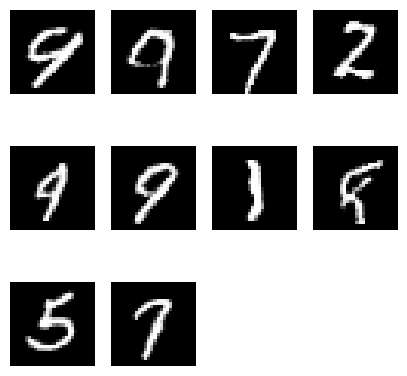

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5052 - g_loss: 1.3880
Epoch 215/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5011 - g_loss: 1.4005

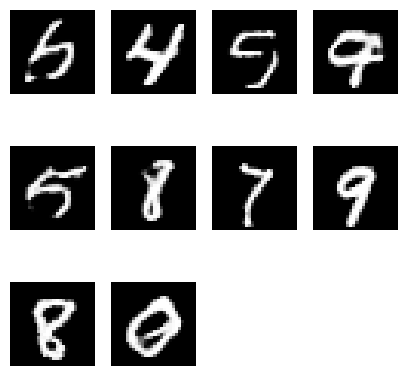

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5011 - g_loss: 1.4005
Epoch 216/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5016 - g_loss: 1.3846

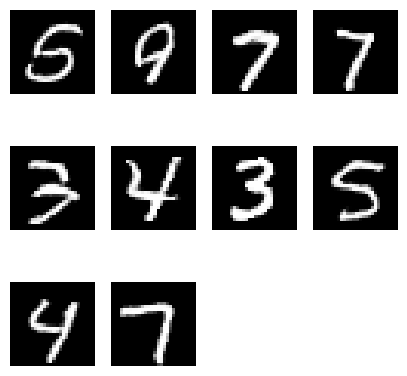

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5016 - g_loss: 1.3846
Epoch 217/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5009 - g_loss: 1.4003

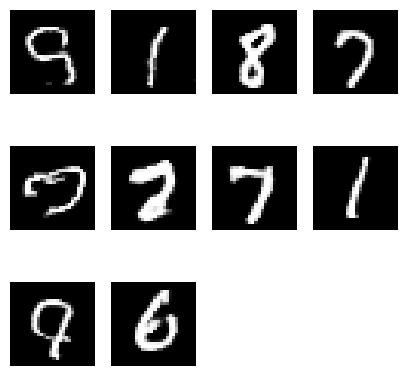

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5009 - g_loss: 1.4003
Epoch 218/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5041 - g_loss: 1.4175

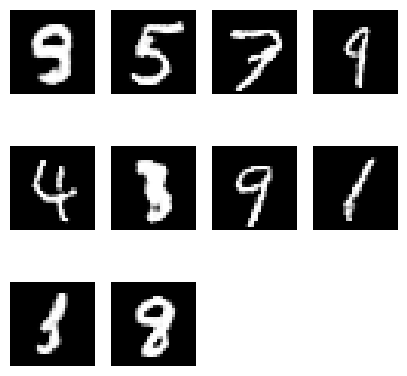

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5041 - g_loss: 1.4174
Epoch 219/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5023 - g_loss: 1.3934

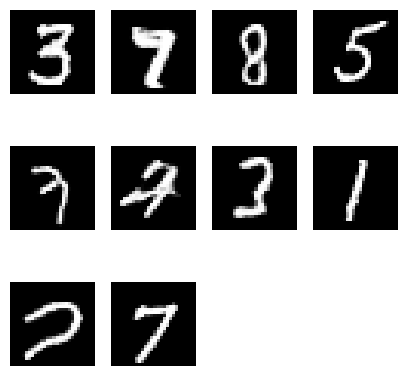

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.5023 - g_loss: 1.3934
Epoch 220/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5024 - g_loss: 1.3852

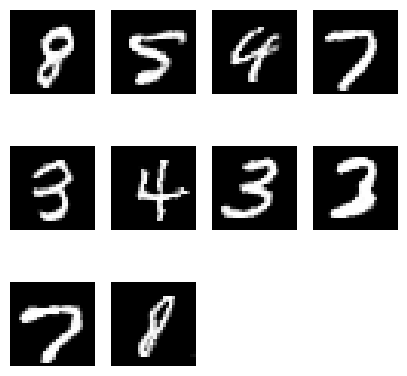

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - d_loss: 0.5024 - g_loss: 1.3852
Epoch 221/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5010 - g_loss: 1.3822

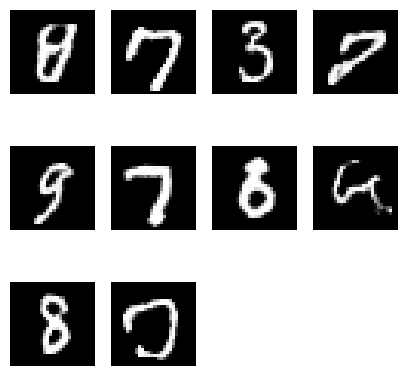

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5010 - g_loss: 1.3822
Epoch 222/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5006 - g_loss: 1.3862

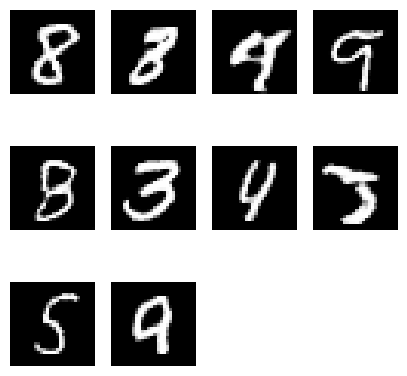

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5006 - g_loss: 1.3862
Epoch 223/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5024 - g_loss: 1.3958

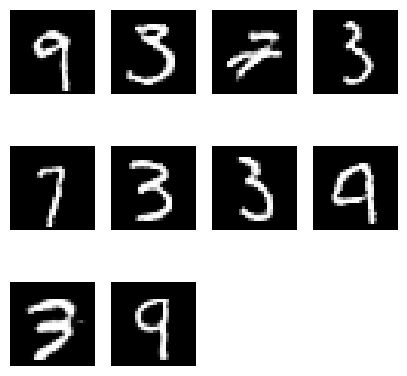

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5024 - g_loss: 1.3958
Epoch 224/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5062 - g_loss: 1.4044

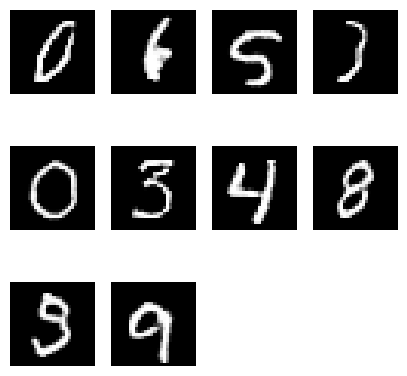

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5062 - g_loss: 1.4044
Epoch 225/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4990 - g_loss: 1.4068

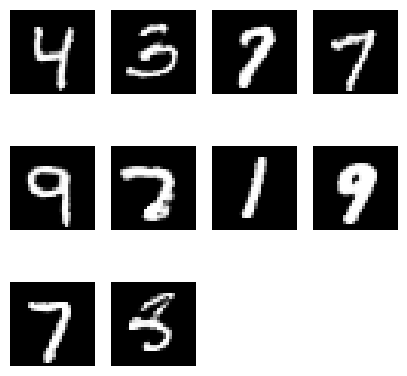

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4990 - g_loss: 1.4068
Epoch 226/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5050 - g_loss: 1.4080

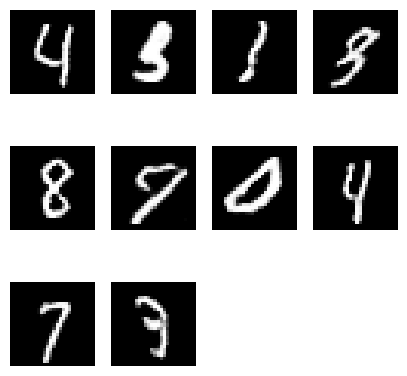

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5050 - g_loss: 1.4079
Epoch 227/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4997 - g_loss: 1.3997

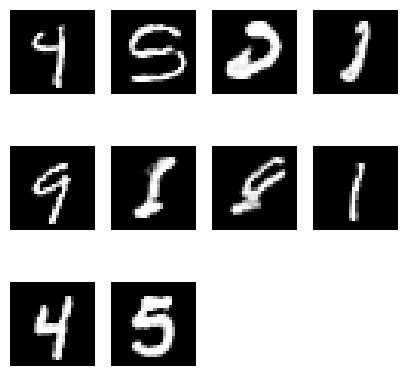

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4997 - g_loss: 1.3997
Epoch 228/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5042 - g_loss: 1.3947

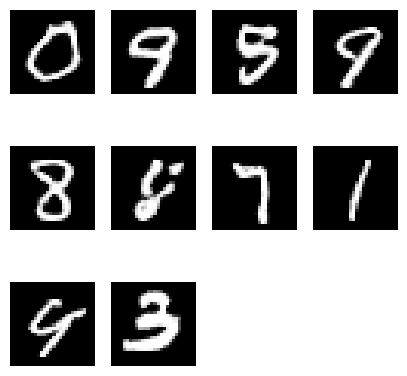

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5042 - g_loss: 1.3947
Epoch 229/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4998 - g_loss: 1.3977

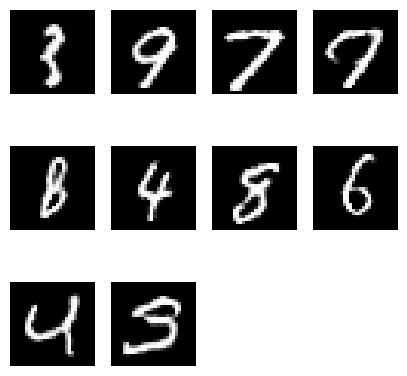

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4998 - g_loss: 1.3977
Epoch 230/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5010 - g_loss: 1.4001

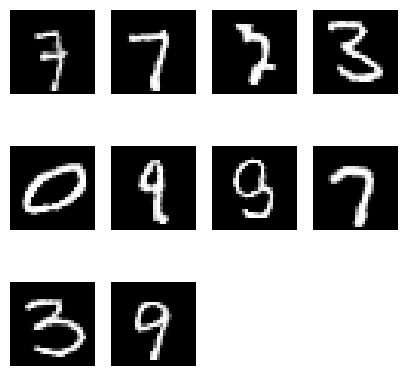

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5010 - g_loss: 1.4000
Epoch 231/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5015 - g_loss: 1.4086

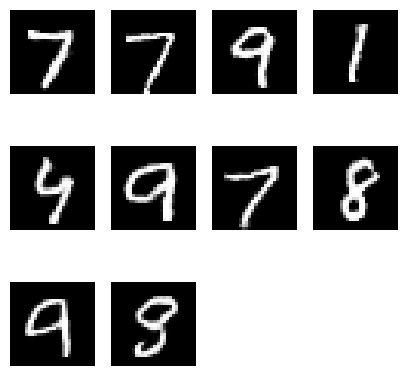

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - d_loss: 0.5015 - g_loss: 1.4086
Epoch 232/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5003 - g_loss: 1.4239

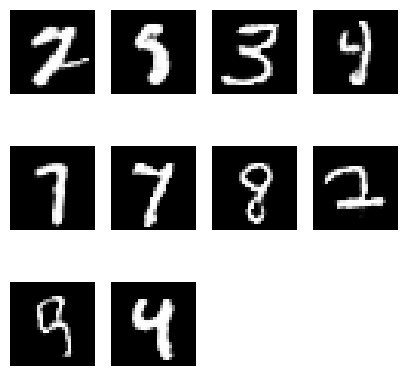

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.5003 - g_loss: 1.4238
Epoch 233/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4995 - g_loss: 1.4045

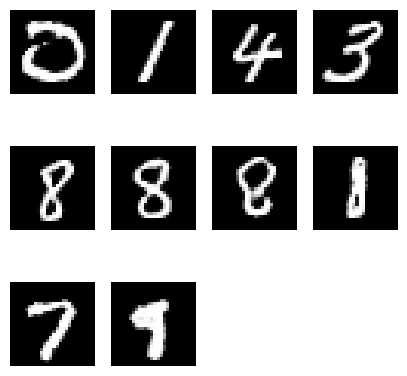

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4995 - g_loss: 1.4045
Epoch 234/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5023 - g_loss: 1.4126

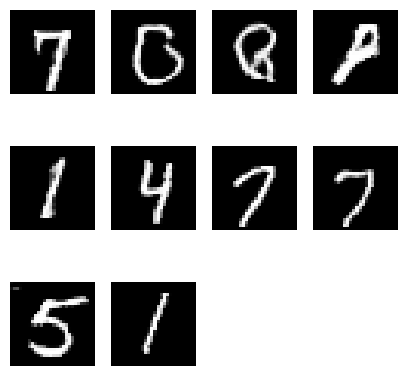

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5023 - g_loss: 1.4125
Epoch 235/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4993 - g_loss: 1.4036

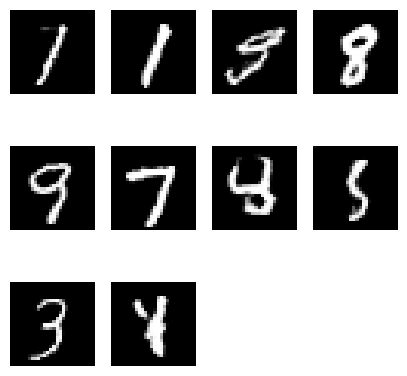

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4993 - g_loss: 1.4036
Epoch 236/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5023 - g_loss: 1.4136

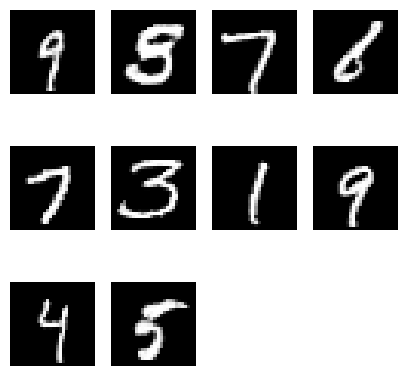

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5023 - g_loss: 1.4136
Epoch 237/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5029 - g_loss: 1.4075

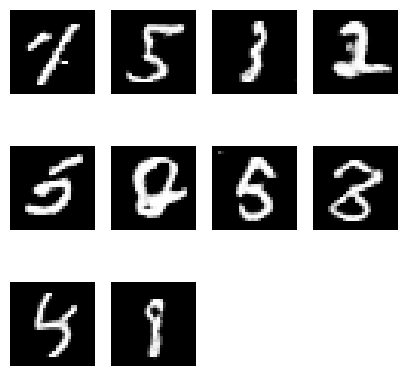

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5029 - g_loss: 1.4075
Epoch 238/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4994 - g_loss: 1.4069

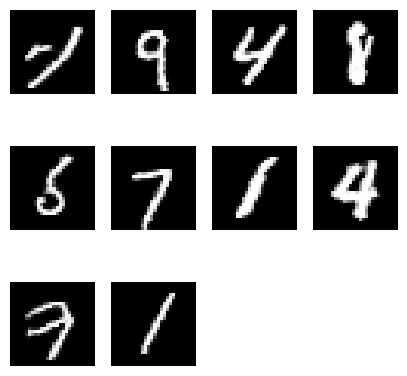

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4994 - g_loss: 1.4069
Epoch 239/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4970 - g_loss: 1.3897

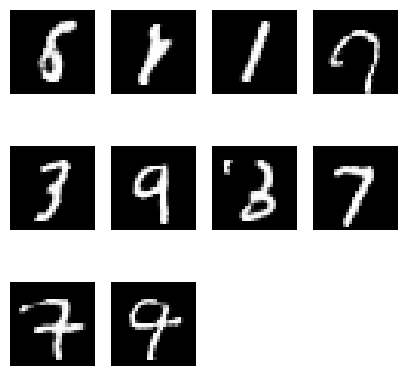

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4970 - g_loss: 1.3897
Epoch 240/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4975 - g_loss: 1.3908

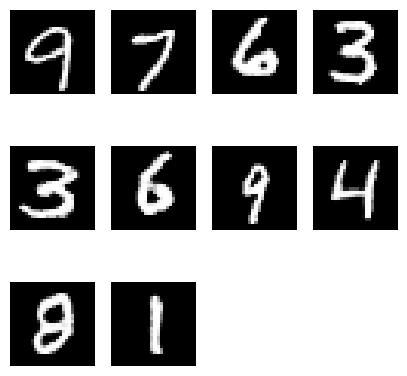

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4975 - g_loss: 1.3908
Epoch 241/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5018 - g_loss: 1.3967

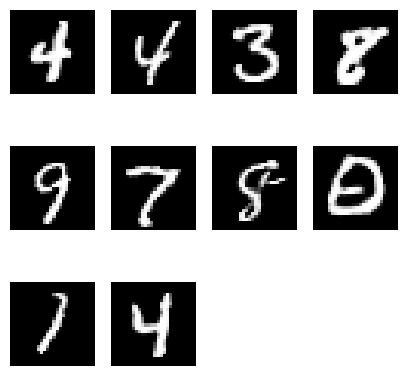

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5018 - g_loss: 1.3968
Epoch 242/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5003 - g_loss: 1.4120

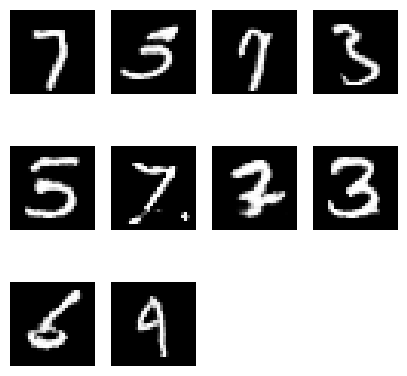

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - d_loss: 0.5002 - g_loss: 1.4120
Epoch 243/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5006 - g_loss: 1.4032

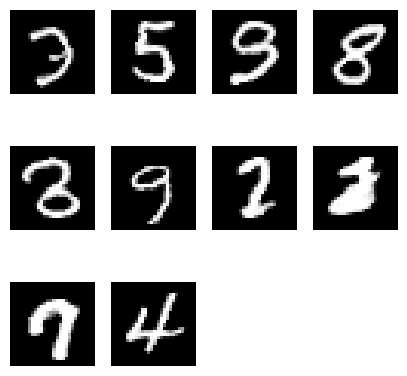

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5006 - g_loss: 1.4032
Epoch 244/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4988 - g_loss: 1.4051

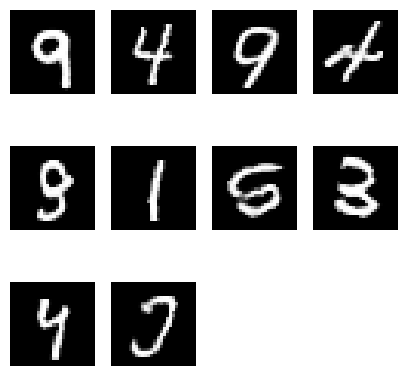

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4988 - g_loss: 1.4051
Epoch 245/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4979 - g_loss: 1.4191

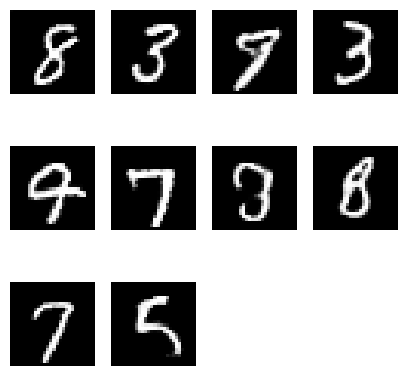

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4979 - g_loss: 1.4191
Epoch 246/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4957 - g_loss: 1.3962

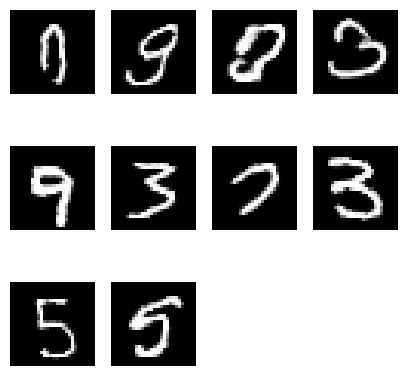

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4957 - g_loss: 1.3962
Epoch 247/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5036 - g_loss: 1.4270

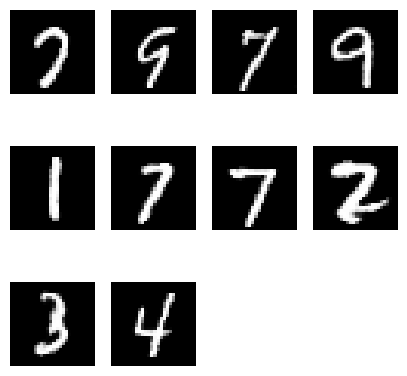

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.5036 - g_loss: 1.4270
Epoch 248/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4979 - g_loss: 1.4228

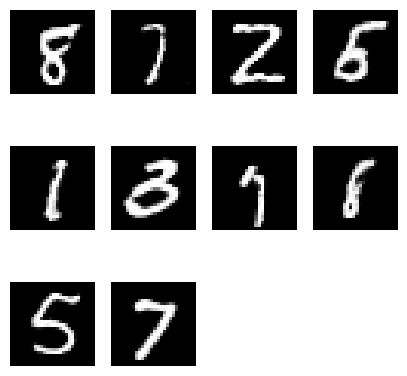

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4979 - g_loss: 1.4228
Epoch 249/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4963 - g_loss: 1.4116

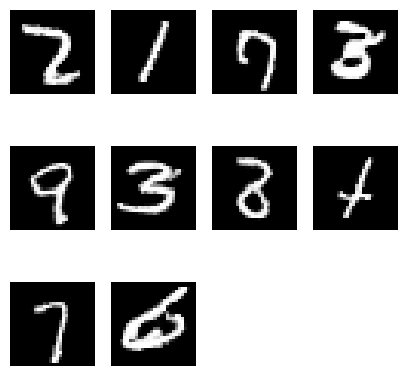

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4963 - g_loss: 1.4116
Epoch 250/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4966 - g_loss: 1.4117

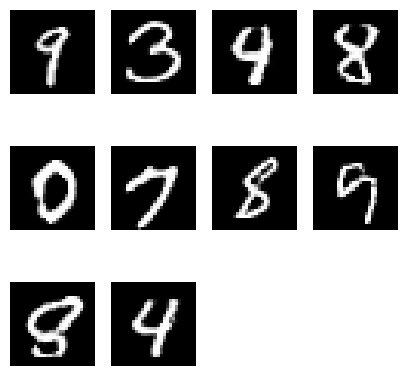

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4966 - g_loss: 1.4117
Epoch 251/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5002 - g_loss: 1.4099

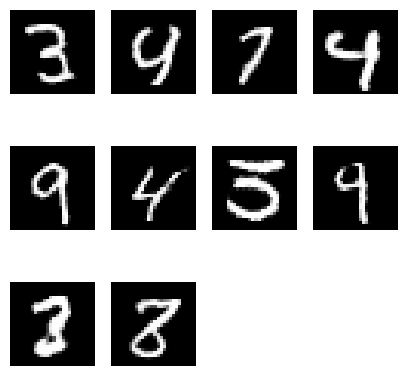

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5002 - g_loss: 1.4099
Epoch 252/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4935 - g_loss: 1.4158

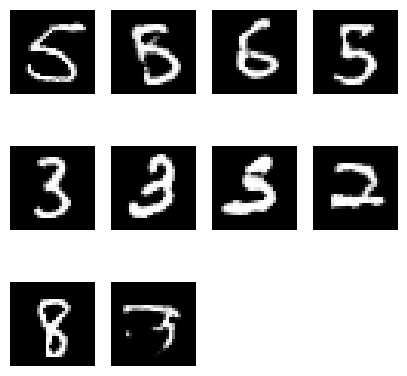

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4935 - g_loss: 1.4158
Epoch 253/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4994 - g_loss: 1.4409

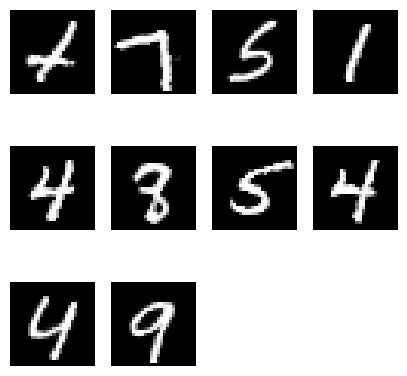

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4994 - g_loss: 1.4409
Epoch 254/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.4981 - g_loss: 1.4077

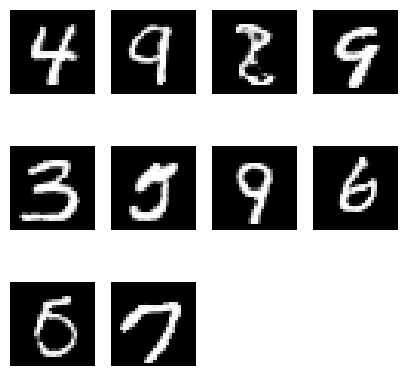

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4980 - g_loss: 1.4078
Epoch 255/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4975 - g_loss: 1.4220

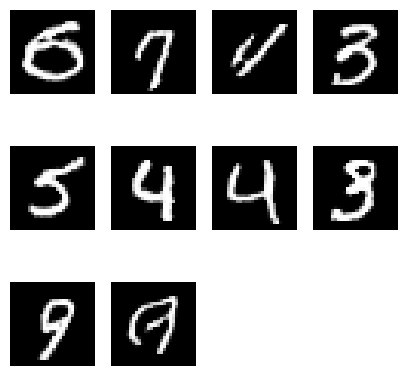

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4975 - g_loss: 1.4220
Epoch 256/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4973 - g_loss: 1.4240

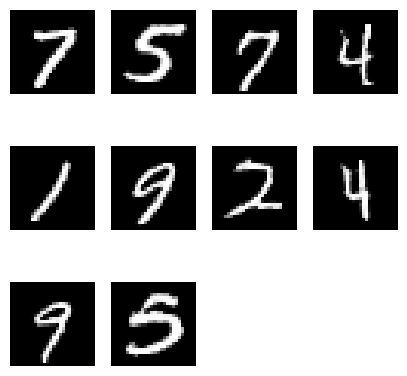

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4973 - g_loss: 1.4239
Epoch 257/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4999 - g_loss: 1.4199

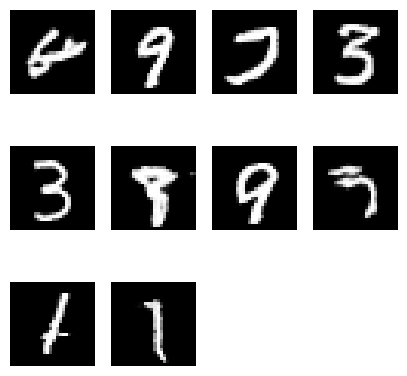

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4999 - g_loss: 1.4199
Epoch 258/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4908 - g_loss: 1.4138

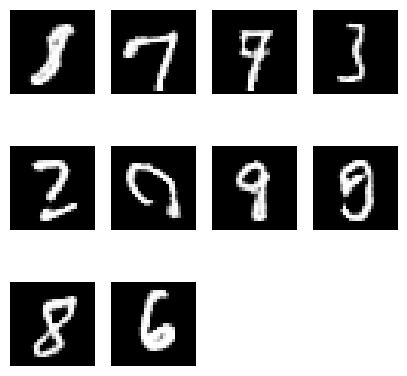

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4908 - g_loss: 1.4137
Epoch 259/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4956 - g_loss: 1.4209

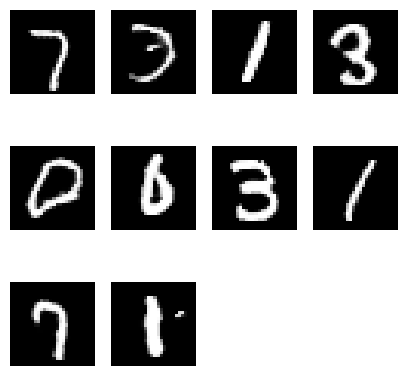

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4956 - g_loss: 1.4209
Epoch 260/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4965 - g_loss: 1.4154

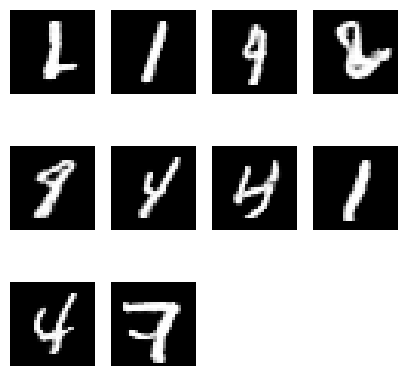

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4965 - g_loss: 1.4154
Epoch 261/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4957 - g_loss: 1.4069

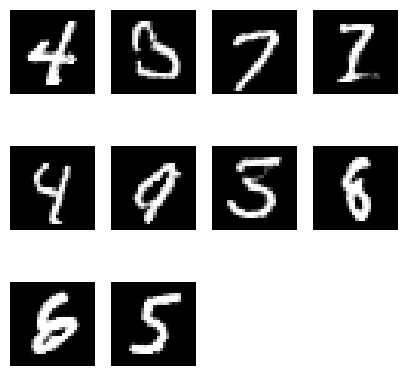

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4957 - g_loss: 1.4069
Epoch 262/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4970 - g_loss: 1.4255

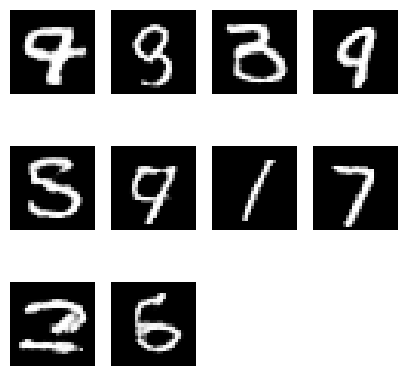

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4970 - g_loss: 1.4255
Epoch 263/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4975 - g_loss: 1.4219

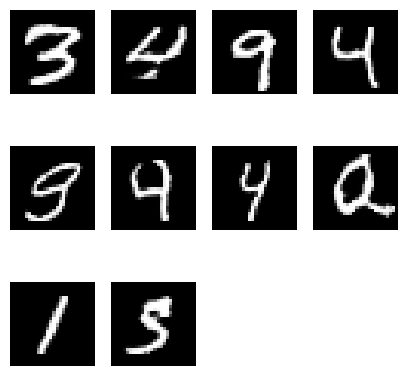

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4975 - g_loss: 1.4219
Epoch 264/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4993 - g_loss: 1.4209

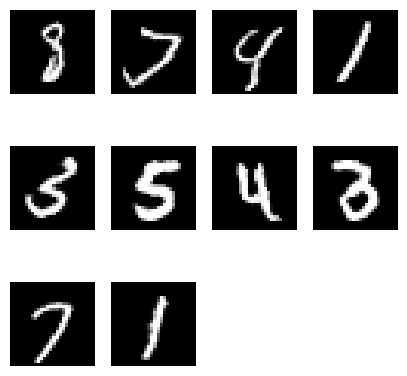

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4993 - g_loss: 1.4209
Epoch 265/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4919 - g_loss: 1.4237

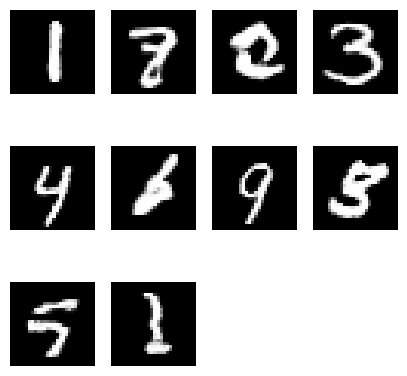

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4919 - g_loss: 1.4237
Epoch 266/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4953 - g_loss: 1.4141

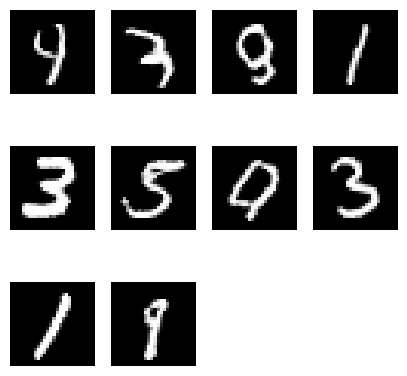

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4953 - g_loss: 1.4141
Epoch 267/300
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4995 - g_loss: 1.4419

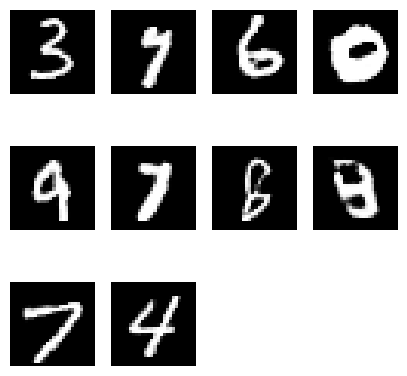

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.4994 - g_loss: 1.4419
Epoch 268/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4974 - g_loss: 1.4487

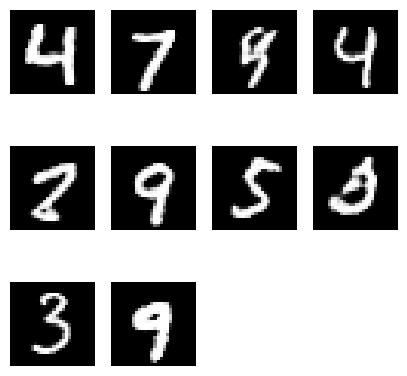

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4974 - g_loss: 1.4487
Epoch 269/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5010 - g_loss: 1.4345

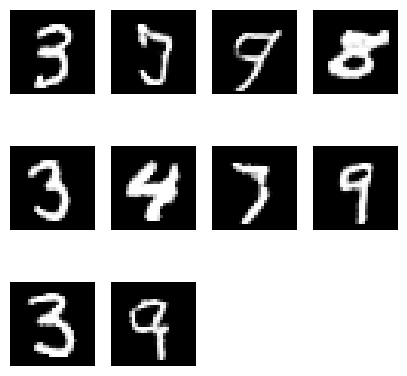

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5010 - g_loss: 1.4345
Epoch 270/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4917 - g_loss: 1.4321

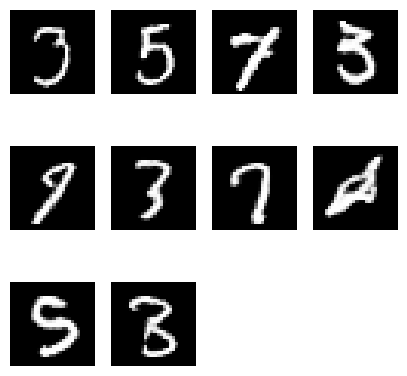

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4917 - g_loss: 1.4321
Epoch 271/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4939 - g_loss: 1.4225

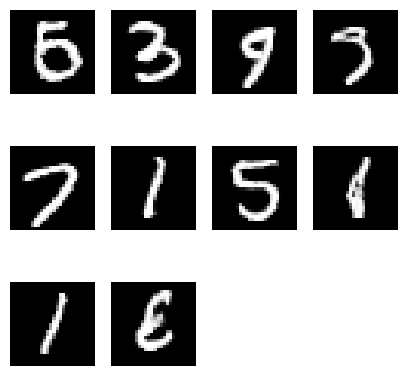

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4939 - g_loss: 1.4225
Epoch 272/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4970 - g_loss: 1.4269

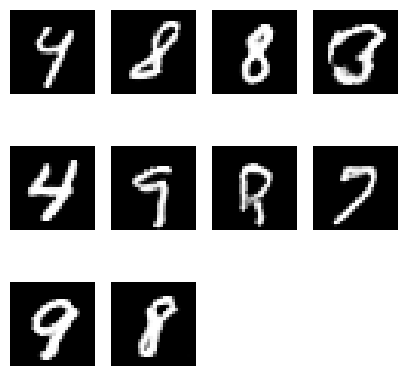

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4970 - g_loss: 1.4269
Epoch 273/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4947 - g_loss: 1.4209

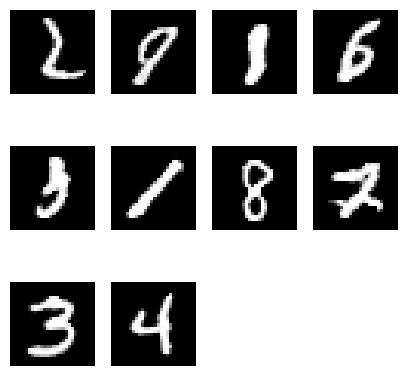

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4947 - g_loss: 1.4208
Epoch 274/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4938 - g_loss: 1.4321

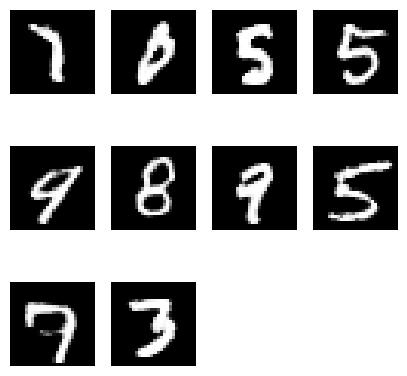

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4938 - g_loss: 1.4321
Epoch 275/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4930 - g_loss: 1.4150

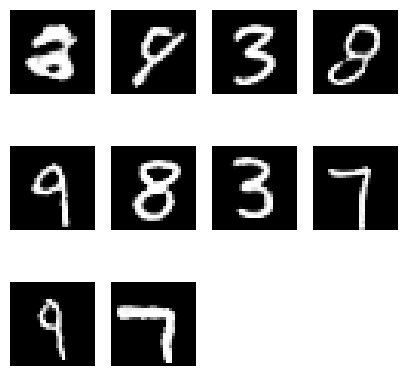

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4930 - g_loss: 1.4150
Epoch 276/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4918 - g_loss: 1.4414

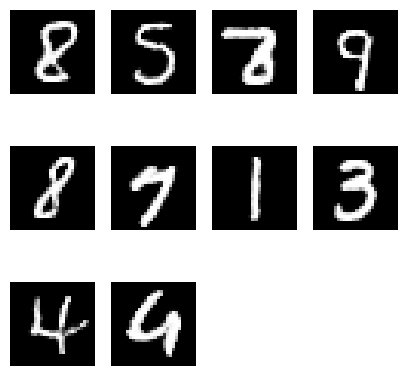

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4918 - g_loss: 1.4414
Epoch 277/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4926 - g_loss: 1.4246

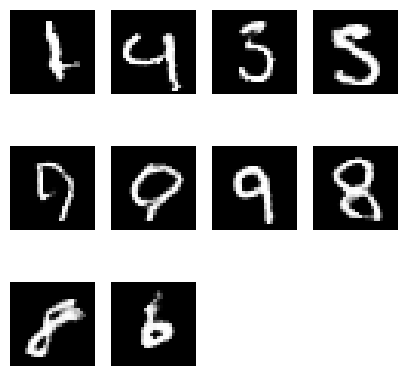

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4926 - g_loss: 1.4246
Epoch 278/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4948 - g_loss: 1.4303

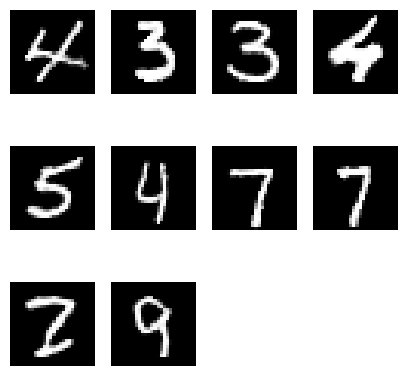

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4948 - g_loss: 1.4303
Epoch 279/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4922 - g_loss: 1.4285

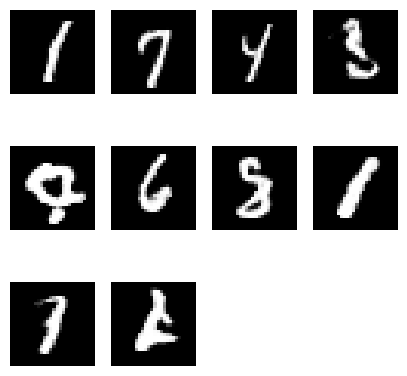

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4922 - g_loss: 1.4285
Epoch 280/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4967 - g_loss: 1.4223

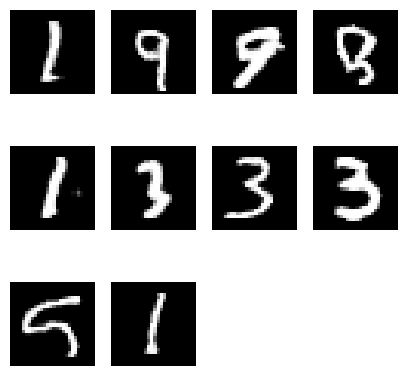

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4967 - g_loss: 1.4223
Epoch 281/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4952 - g_loss: 1.4361

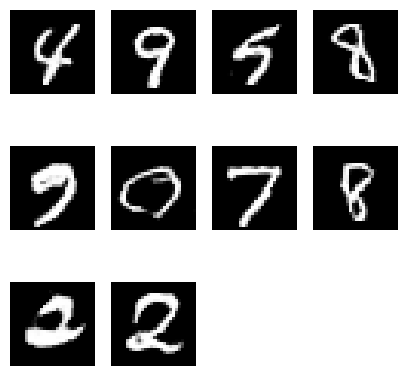

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4952 - g_loss: 1.4360
Epoch 282/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4912 - g_loss: 1.4326

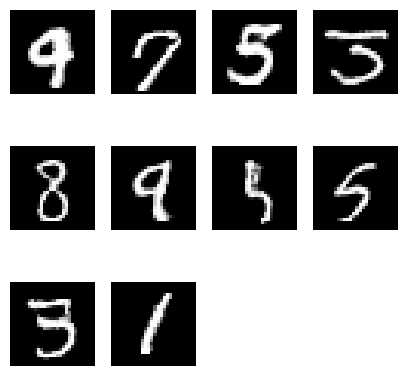

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4912 - g_loss: 1.4326
Epoch 283/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4988 - g_loss: 1.4699

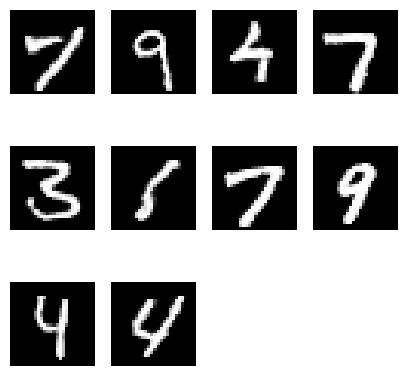

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4988 - g_loss: 1.4699
Epoch 284/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4923 - g_loss: 1.4175

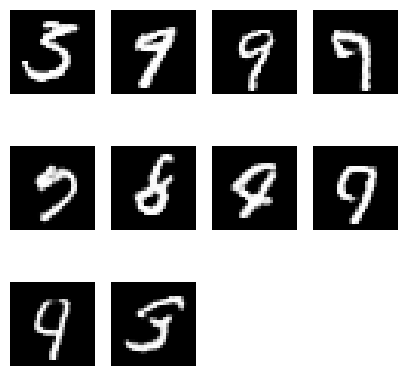

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4923 - g_loss: 1.4175
Epoch 285/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4888 - g_loss: 1.4335

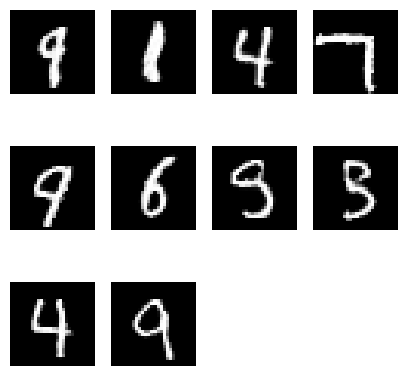

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4888 - g_loss: 1.4335
Epoch 286/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4935 - g_loss: 1.4445

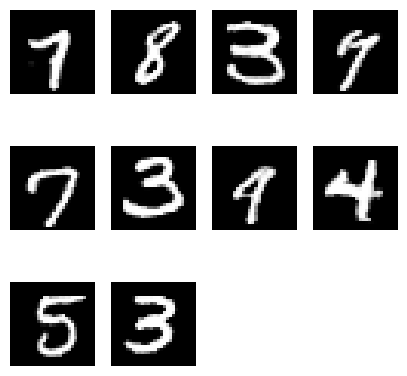

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4935 - g_loss: 1.4444
Epoch 287/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4971 - g_loss: 1.4497

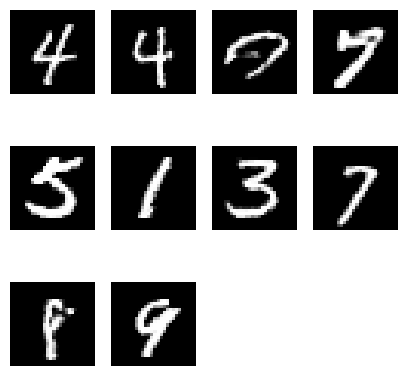

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - d_loss: 0.4971 - g_loss: 1.4497
Epoch 288/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4925 - g_loss: 1.4381

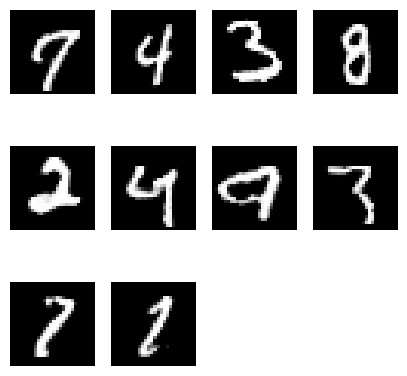

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4925 - g_loss: 1.4381
Epoch 289/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4955 - g_loss: 1.4387

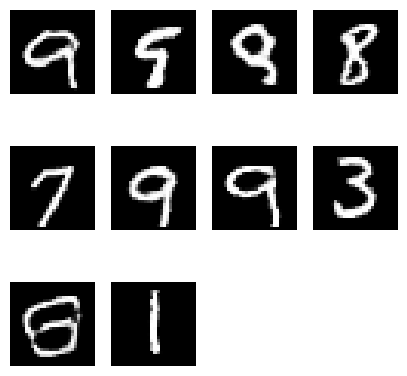

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4955 - g_loss: 1.4387
Epoch 290/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4950 - g_loss: 1.4170

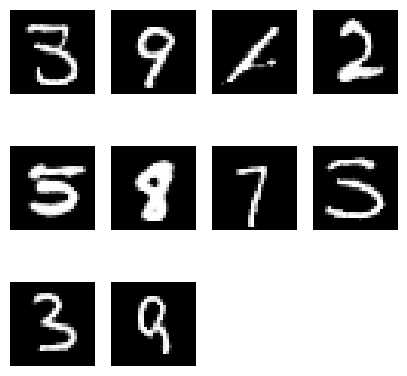

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4950 - g_loss: 1.4170
Epoch 291/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4971 - g_loss: 1.4470

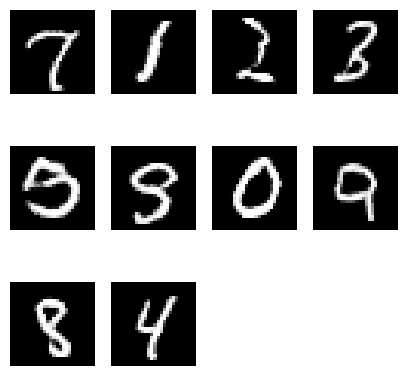

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4970 - g_loss: 1.4470
Epoch 292/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4922 - g_loss: 1.4446

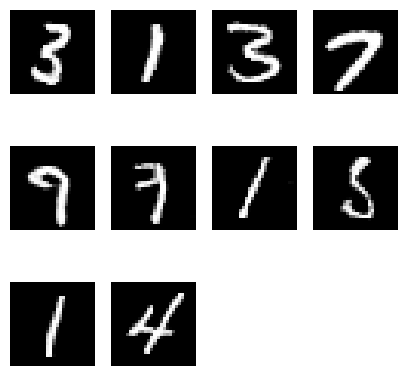

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4922 - g_loss: 1.4446
Epoch 293/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4942 - g_loss: 1.4463

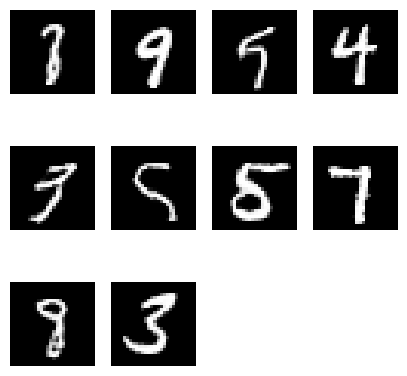

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4942 - g_loss: 1.4462
Epoch 294/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4941 - g_loss: 1.4433

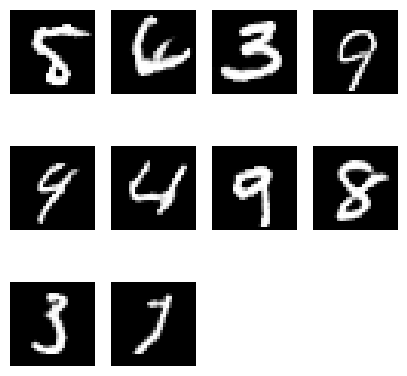

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4941 - g_loss: 1.4433
Epoch 295/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4927 - g_loss: 1.4472

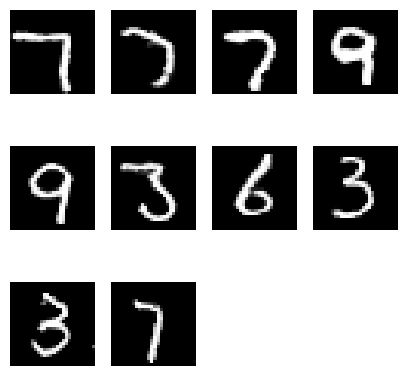

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4927 - g_loss: 1.4472
Epoch 296/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4972 - g_loss: 1.4640

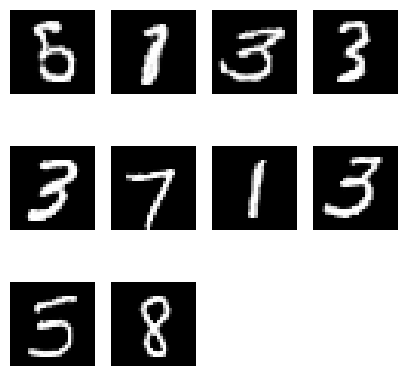

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4972 - g_loss: 1.4639
Epoch 297/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4877 - g_loss: 1.4331

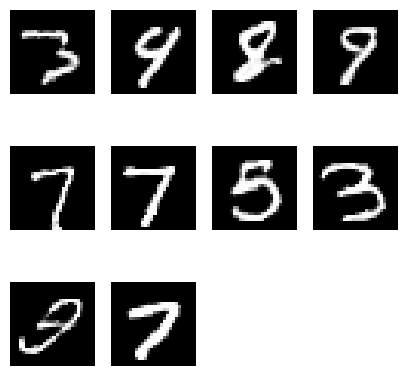

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4877 - g_loss: 1.4331
Epoch 298/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4889 - g_loss: 1.4362

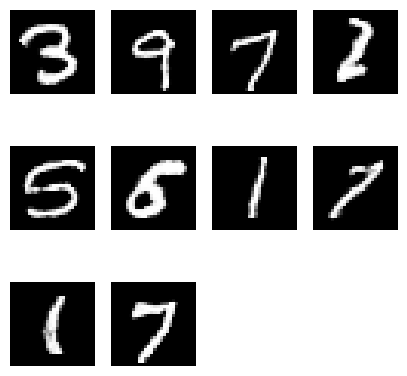

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4889 - g_loss: 1.4362
Epoch 299/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4931 - g_loss: 1.4634

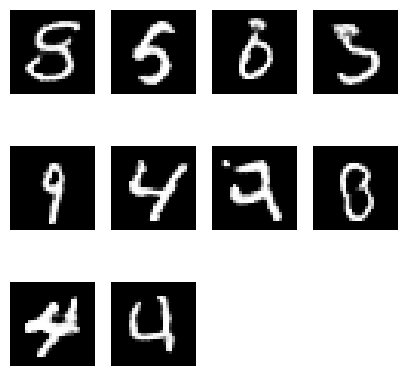

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4931 - g_loss: 1.4634
Epoch 300/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4926 - g_loss: 1.4597

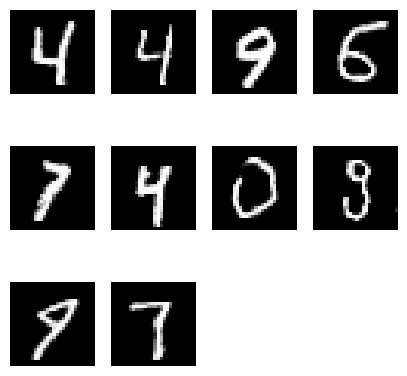

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4926 - g_loss: 1.4596


In [19]:
epochs = 300  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)